In [1]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%load_ext autoreload
%autoreload 1

Author: Andrew Tarzia

Date Created: 11 Sep 2018

Distributed under the terms of the MIT License.

# Notebook to find new reactions from a set of EC numbers for enzymatic catalysis in ZIFs

In [2]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Alphabet import IUPAC
from rdkit.Chem.Draw import IPythonConsole  # to show molecules in notebook
import time
import numpy as np
import pandas as pd
# ensure cpickle usage
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors3D import NPR1, NPR2, PMI1, PMI2, PMI3
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Geometry import rdGeometry
from rdkit.Chem import PyMol
from rdkit import Geometry
import tempfile
%aimport pi_fn
%aimport parameters
%aimport BRENDA_IO
%aimport SABIO_IO
%aimport rdkit_functions
%aimport ellipsoid
%aimport DB_functions
%aimport CHEBI_IO
%aimport BKMS_IO
%aimport KEGG_IO
%aimport Uniprot_IO
%aimport PUBCHEM_IO
%aimport rxn_syst

# Calculate pI of all sequences in EC No. used in literature
## Produces distribution for each EC No.

## Notes:
### Biopython:
- pK values and the methods are taken from::
    * Bjellqvist, B.,Hughes, G.J., Pasquali, Ch., Paquet, N., Ravier, F.,
    Sanchez, J.-Ch., Frutiger, S. & Hochstrasser, D.F.
    The focusing positions of polypeptides in immobilized pH gradients can be
    predicted from their amino acid sequences. Electrophoresis 1993, 14,
    1023-1031.
    * Bjellqvist, B., Basse, B., Olsen, E. and Celis, J.E.
    Reference points for comparisons of two-dimensional maps of proteins from
    different human cell types defined in a pH scale where isoelectric points
    correlate with polypeptide compositions. Electrophoresis 1994, 15, 529-539.

|  AA | pKa  |
|-----|------|
| ASP | 4.05 |
| GLU | 4.45 |
| HIS | 5.98 |
| CYS | 9.00 |
| TYR | 10.0 |
| LYS | 10.0 |
| ARG | 12.0 |
| N-terminus | 7.50 |
| N-terminus : GLU | 7.7 |
| N-terminus : VAL | 7.44 |
| N-terminus : THR | 6.82 |
| N-terminus : PRO | 8.36 |
| N-terminus : SER | 6.93 |
| N-terminus : MET | 7.00 |
| N-terminus : ALA | 7.59 |
| C-terminus | 3.55 |
| C-terminus : ASP | 4.55 |
| C-terminus : GLU | 4.75 |

- with the above pKas and the data set in Tash's paper (DOI:) we apply a pI cut off = XX.


### Modified pIs:
- assuming sequence only and therefore cannot use DSSP to calculate exposure

In [5]:
# get parameters
param_dict = parameters.get_parameters()

# input parameters
database_directory = '/home/atarzia/psp/screening_results/new_reactions/sequences/'
output_dir = database_directory

In [6]:
# get input FASTA file names
database_names = []
for i in glob.glob(database_directory+"*fasta"):
    if "_mod" not in i:
        database_names.append(i)
database_names = sorted(database_names)
print('databases:')
for i in database_names:
    print('--', i.replace(database_directory, ''))

# prepare output CSV file
redo_pi = input('redo pI calculation (True = yes, False = no)')
if redo_pi == 'True':
    redo_pi = True
    pi_fn.prepare_out_csv(output_dir, param_dict)
    # fix formatting of FASTA files to match BIOPYTHON readable
    pi_fn.fix_fasta(database_names)

databases:
-- 4__BRENDA_sequences.fasta
-- 5__BRENDA_sequences.fasta
redo pI calculation (True = yes, False = no)True


calculate all pIs for target EC sequences
doing: /home/atarzia/psp/screening_results/new_reactions/sequences/4__BRENDA_sequences.fasta
--- finished 1468675 sequences in 381.56 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/screening_results/new_reactions/sequences/5__BRENDA_sequences.fasta
--- finished 909334 sequences in 274.90 seconds ---
plot distribution of pIs
done


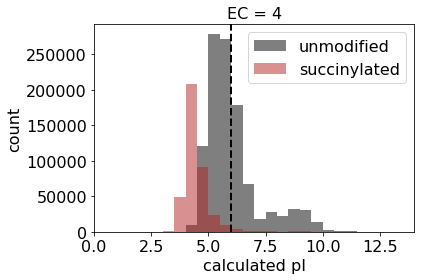

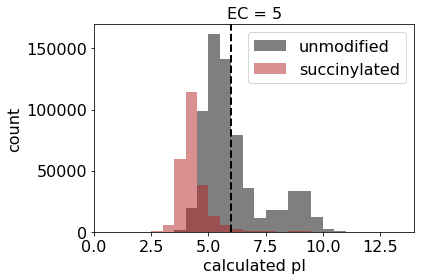

In [7]:
print('calculate all pIs for target EC sequences')
for EC_file in database_names:
    # read the file
    # but to avoid memory issues
    # we will calculate the pI on the fly
    # using the bio python module
    print('doing:', EC_file)
    file_mod = EC_file.replace(".fasta", "_mod.fasta")
    if redo_pi is True:
        pi_fn.calculate_pI_from_file(file_mod, param_dict, output_dir)
    print('plot distribution of pIs')
    pi_data = pd.read_csv(output_dir+param_dict['out_CSV_pi'], index_col=False)
    EC_pi_data = pi_data[pi_data['fasta_file'] == file_mod]
    pi_fn.plot_EC_pI_dist(EC_pi_data, param_dict,
                          filename=file_mod.replace('.fasta', '.pdf'),
                          title=file_mod.replace(output_dir, '').replace('__BRENDA_sequences_mod.fasta', ''))
    print('done')

# Collect reactant-product systems 
suggest new reactions!

### Collect all reaction systems from multiple databases
Online.

In [3]:
# set output directory
output_dir = '/home/atarzia/psp/screening_results/new_reactions/'

# set databases to search to collect reaction systems
# BKMS should always be last as the culmination of all DBs
Databases = ['BRENDA', 'BKMS', 'SABIO', 'KEGG', ]

# set EC numbers of interest
# get from a data file - manually made from https://enzyme.expasy.org/enzyme-byclass.html
EC_file = output_dir+'desired_EC.txt'
EC_DF = pd.read_table(EC_file, delimiter='__', names=['EC_no', 'description'], engine='python')
EC_int = list(EC_DF['EC_no'])

# csv file with molecular output
mol_output_file = output_dir+'screening_output.csv'
molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)

In [4]:
print(len(EC_int), 'EC numbers to test')
print('first EC:', EC_int[0], '---- last EC:', EC_int[-1])

1129 EC numbers to test
first EC: 4.1.1.1 ---- last EC: 5.99.1.4


In [9]:
for DB in Databases:
    # get database specific information
    DB_prop = DB_functions.get_DB_prop(DB)
    db_dir = DB_prop[0]
    # iterate over EC numbers of interest
    for EC in EC_int:
        print('doing:', DB, 'EC:', EC)
        rxn_syst.get_reaction_systems(EC, DB, output_dir, clean_system=False, verbose=False)

doing: BKMS EC: 4.1.1.1
doing: BKMS EC: 4.1.1.2
doing: BKMS EC: 4.1.1.3
doing: BKMS EC: 4.1.1.4
doing: BKMS EC: 4.1.1.5
doing: BKMS EC: 4.1.1.6
doing: BKMS EC: 4.1.1.7
doing: BKMS EC: 4.1.1.8
doing: BKMS EC: 4.1.1.9
doing: BKMS EC: 4.1.1.10
doing: BKMS EC: 4.1.1.11
doing: BKMS EC: 4.1.1.12
doing: BKMS EC: 4.1.1.13
doing: BKMS EC: 4.1.1.14
doing: BKMS EC: 4.1.1.15
doing: BKMS EC: 4.1.1.16
doing: BKMS EC: 4.1.1.17
doing: BKMS EC: 4.1.1.18
doing: BKMS EC: 4.1.1.19
doing: BKMS EC: 4.1.1.20
doing: BKMS EC: 4.1.1.21
doing: BKMS EC: 4.1.1.22
doing: BKMS EC: 4.1.1.23
doing: BKMS EC: 4.1.1.24
doing: BKMS EC: 4.1.1.25
doing: BKMS EC: 4.1.1.26
doing: BKMS EC: 4.1.1.27
doing: BKMS EC: 4.1.1.28
doing: BKMS EC: 4.1.1.29
doing: BKMS EC: 4.1.1.30
doing: BKMS EC: 4.1.1.31
doing: BKMS EC: 4.1.1.32
doing: BKMS EC: 4.1.1.33
doing: BKMS EC: 4.1.1.34
doing: BKMS EC: 4.1.1.35
doing: BKMS EC: 4.1.1.36
doing: BKMS EC: 4.1.1.37
doing: BKMS EC: 4.1.1.38
doing: BKMS EC: 4.1.1.39
doing: BKMS EC: 4.1.1.40
doing: BK

doing: BKMS EC: 4.2.1.82
doing: BKMS EC: 4.2.1.83
doing: BKMS EC: 4.2.1.84
doing: BKMS EC: 4.2.1.85
doing: BKMS EC: 4.2.1.86
doing: BKMS EC: 4.2.1.87
doing: BKMS EC: 4.2.1.88
doing: BKMS EC: 4.2.1.89
doing: BKMS EC: 4.2.1.90
doing: BKMS EC: 4.2.1.91
doing: BKMS EC: 4.2.1.92
doing: BKMS EC: 4.2.1.93
doing: BKMS EC: 4.2.1.94
doing: BKMS EC: 4.2.1.95
doing: BKMS EC: 4.2.1.96
doing: BKMS EC: 4.2.1.97
doing: BKMS EC: 4.2.1.98
doing: BKMS EC: 4.2.1.99
doing: BKMS EC: 4.2.1.100
doing: BKMS EC: 4.2.1.101
doing: BKMS EC: 4.2.1.102
doing: BKMS EC: 4.2.1.103
doing: BKMS EC: 4.2.1.104
doing: BKMS EC: 4.2.1.105
doing: BKMS EC: 4.2.1.106
doing: BKMS EC: 4.2.1.107
doing: BKMS EC: 4.2.1.108
doing: BKMS EC: 4.2.1.109
doing: BKMS EC: 4.2.1.110
doing: BKMS EC: 4.2.1.111
doing: BKMS EC: 4.2.1.112
doing: BKMS EC: 4.2.1.113
doing: BKMS EC: 4.2.1.114
doing: BKMS EC: 4.2.1.115
doing: BKMS EC: 4.2.1.116
doing: BKMS EC: 4.2.1.117
doing: BKMS EC: 4.2.1.118
doing: BKMS EC: 4.2.1.119
doing: BKMS EC: 4.2.1.120
doin

doing: BKMS EC: 4.2.3.n5
doing: BKMS EC: 4.2.3.n6
doing: BKMS EC: 4.2.3.n7
doing: BKMS EC: 4.2.3.n8
doing: BKMS EC: 4.2.3.n9
doing: BKMS EC: 4.2.3.n10
doing: BKMS EC: 4.2.3.n11
doing: BKMS EC: 4.2.3.n12
doing: BKMS EC: 4.2.3.n13
doing: BKMS EC: 4.2.3.n14
doing: BKMS EC: 4.2.99.1
doing: BKMS EC: 4.2.99.2
doing: BKMS EC: 4.2.99.3
doing: BKMS EC: 4.2.99.4
doing: BKMS EC: 4.2.99.5
doing: BKMS EC: 4.2.99.6
doing: BKMS EC: 4.2.99.7
doing: BKMS EC: 4.2.99.8
doing: BKMS EC: 4.2.99.9
doing: BKMS EC: 4.2.99.10
doing: BKMS EC: 4.2.99.11
doing: BKMS EC: 4.2.99.12
doing: BKMS EC: 4.2.99.13
doing: BKMS EC: 4.2.99.14
doing: BKMS EC: 4.2.99.15
doing: BKMS EC: 4.2.99.16
doing: BKMS EC: 4.2.99.17
doing: BKMS EC: 4.2.99.18
doing: BKMS EC: 4.2.99.19
doing: BKMS EC: 4.2.99.20
doing: BKMS EC: 4.2.99.21
doing: BKMS EC: 4.2.99.22
doing: BKMS EC: 4.2.99.23
doing: BKMS EC: 4.2.99.n1
doing: BKMS EC: 4.3.1.1
doing: BKMS EC: 4.3.1.2
doing: BKMS EC: 4.3.1.3
doing: BKMS EC: 4.3.1.4
doing: BKMS EC: 4.3.1.5
doing: BKM

doing: BKMS EC: 5.3.1.6
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
no match in DB
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
doing: BKMS EC: 5.3.1.7
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
doing: BKMS EC: 5.3.1.8
molecule does not have recorded s

RDKit WARNING: [09:53:23]  S group SUP ignored on line 65
RDKit WARNING: [09:53:23]  S group SUP ignored on line 65


doing: BKMS EC: 5.3.1.22
doing: BKMS EC: 5.3.1.23
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
doing: BKMS EC: 5.3.1.24
doing: BKMS EC: 5.3.1.25
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
doing: BKMS EC: 5.3.1.26
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUB

RDKit WARNING: [09:56:40]  S group SUP ignored on line 63
RDKit WARNING: [09:56:40]  S group SUP ignored on line 63
RDKit WARNING: [09:56:40]  S group SUP ignored on line 63
RDKit WARNING: [09:56:41]  S group SUP ignored on line 63
RDKit WARNING: [09:56:41]  S group SUP ignored on line 63
RDKit WARNING: [09:56:41]  S group SUP ignored on line 63
RDKit WARNING: [09:56:42]  S group SUP ignored on line 63
RDKit WARNING: [09:56:42]  S group SUP ignored on line 63
RDKit WARNING: [09:56:42]  S group SUP ignored on line 63


no match in DB
reaction is reversible
reaction is reversible


RDKit WARNING: [09:56:51]  S group SUP ignored on line 67
RDKit WARNING: [09:56:51]  S group SUP ignored on line 67


reaction is reversible


RDKit WARNING: [09:56:53]  S group SUP ignored on line 62
RDKit WARNING: [09:56:53]  S group SUP ignored on line 62
RDKit WARNING: [09:56:53]  S group SUP ignored on line 62
RDKit WARNING: [09:56:53]  S group SUP ignored on line 63
RDKit WARNING: [09:56:53]  S group SUP ignored on line 63
RDKit WARNING: [09:56:53]  S group SUP ignored on line 63


reaction is reversible


RDKit WARNING: [09:56:55]  S group SUP ignored on line 65
RDKit WARNING: [09:56:55]  S group SUP ignored on line 65


reaction is reversible
reaction is reversible


RDKit WARNING: [09:56:59]  S group SUP ignored on line 65
RDKit WARNING: [09:56:59]  S group SUP ignored on line 65
RDKit WARNING: [09:57:00]  S group SUP ignored on line 65
RDKit WARNING: [09:57:00]  S group SUP ignored on line 65


reaction is reversible
no match in DB
no match in DB


RDKit WARNING: [09:57:11]  S group SUP ignored on line 63
RDKit WARNING: [09:57:11]  S group SUP ignored on line 63
RDKit WARNING: [09:57:11]  S group SUP ignored on line 63


doing: BKMS EC: 5.3.3.2
doing: BKMS EC: 5.3.3.3
doing: BKMS EC: 5.3.3.4
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
no match in DB
doing: BKMS EC: 5.3.3.5
no match in DB
no match in DB
reaction is reversible
no match in DB
no match in DB
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
doing: BKMS EC: 5.3.3.6
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
doing: BKMS EC: 5.3.3.7
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
doing: BKMS EC: 5.3.3.8
no match in DB
no match in DB
no match in DB
no match in DB
no match in DB
no match in DB
no match in DB
no match in DB
no match in DB
reaction is reversible
no match in DB
no match in DB
no match in DB
no match in DB
no match in DB
doing: BKMS EC: 5.3.3.9
doing: BKMS EC: 5.3.3.10
reaction is 

RDKit WARNING: [10:02:57]  S group SUP ignored on line 33
RDKit WARNING: [10:02:57]  S group SUP ignored on line 33


molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
reaction is reversible
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
doing: BKMS EC: 5.4.2.7
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
no match in DB
no match in DB
doing: BKMS EC: 5.4.2.8
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
doing: BKMS EC: 5.4

RDKit WARNING: [10:07:41]  S group SUP ignored on line 78
RDKit WARNING: [10:07:41]  S group SUP ignored on line 78
RDKit WARNING: [10:07:41]  S group SUP ignored on line 78
RDKit WARNING: [10:07:41]  S group SUP ignored on line 78
RDKit WARNING: [10:07:41]  S group SUP ignored on line 78
RDKit WARNING: [10:07:41]  S group SUP ignored on line 78
RDKit WARNING: [10:07:41]  S group SUP ignored on line 78


molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
doing: BKMS EC: 5.4.99.18
doing: BKMS EC: 5.4.99.19
no match in DB
no match in DB
doing: BKMS EC: 5.4.99.20
no match in DB
no match in DB
doing: BKMS EC: 5.4.99.21
no match in DB
no match in DB
doing: BKMS EC: 5.4.99.22
no match in DB
no match in DB
doing: BKMS EC: 5.4.99.23
no match in DB
no match in DB
doing: BKMS EC: 5.4.99.24
no match in DB
no match in DB
doing: BKMS EC: 5.4.99.25
no match in DB
no match in DB
doing: BKMS EC: 5.4.99.26
no match in DB
no match in DB
doing: BKMS EC: 5.4.99.27
no match in DB
no match in DB
doing: BKMS EC: 5.4.99.28
no match in DB
no match in DB
doing: BKMS EC: 5.4.99.29
no match in DB
no match in DB
doing: BKMS EC: 5.4.99.30
doing: BKMS EC: 5.4.99.31
doing: BKMS EC: 5.4.99.32
doing: BKMS EC: 5.4.99.33
doing: BKMS EC: 5.4.99.34
doing: BKMS EC: 5.4.99.35
doing: BKMS EC: 5.4.99.36
doing: BKMS EC: 5.4.99.37
doing: BKMS EC: 5.4.99.38
doing: BKMS EC

RDKit WARNING: [10:10:07]  S group SUP ignored on line 144
RDKit WARNING: [10:10:07]  S group SUP ignored on line 144
RDKit WARNING: [10:10:07]  S group SUP ignored on line 144
RDKit WARNING: [10:10:07]  S group SUP ignored on line 144
RDKit WARNING: [10:10:07]  S group SUP ignored on line 144
RDKit WARNING: [10:10:07]  S group SUP ignored on line 144
RDKit WARNING: [10:10:07]  S group SUP ignored on line 144
RDKit WARNING: [10:10:07]  S group SUP ignored on line 144
RDKit ERROR: [10:10:07] Explicit valence for atom # 7 N, 4, is greater than permitted


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM
doing: BKMS EC: 5.4.99.61


RDKit WARNING: [10:10:10]  S group SUP ignored on line 138
RDKit WARNING: [10:10:10]  S group SUP ignored on line 138
RDKit WARNING: [10:10:10]  S group SUP ignored on line 138
RDKit WARNING: [10:10:10]  S group SUP ignored on line 138
RDKit WARNING: [10:10:10]  S group SUP ignored on line 138
RDKit WARNING: [10:10:10]  S group SUP ignored on line 138
RDKit WARNING: [10:10:10]  S group SUP ignored on line 138
RDKit WARNING: [10:10:10]  S group SUP ignored on line 138
RDKit WARNING: [10:10:10]  S group SUP ignored on line 138
RDKit WARNING: [10:10:10]  S group SUP ignored on line 138
RDKit WARNING: [10:10:10]  S group SUP ignored on line 138
RDKit WARNING: [10:10:10]  S group SUP ignored on line 138
RDKit WARNING: [10:10:10]  S group SUP ignored on line 138
RDKit WARNING: [10:10:10]  S group SUP ignored on line 138
RDKit WARNING: [10:10:10]  S group SUP ignored on line 138
RDKit WARNING: [10:10:10]  S group SUP ignored on line 138


doing: BKMS EC: 5.4.99.62
no match in DB
no match in DB
doing: BKMS EC: 5.4.99.63
doing: BKMS EC: 5.4.99.64
no match in DB
doing: BKMS EC: 5.4.99.65
doing: BKMS EC: 5.4.99.66
doing: BKMS EC: 5.4.99.n1
doing: BKMS EC: 5.4.99.n2
doing: BKMS EC: 5.5.1.1
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
no match in DB
no match in DB
no match in DB
reaction is reversible
doing: BKMS EC: 5.5.1.2
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
doing: BKMS EC: 5.5.1.3
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
doing: BKMS EC: 5.5.1.4
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
no match in DB
doing: BKMS EC: 5.5.1.5
doing: BKMS EC: 5.5.1.6
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBC

RDKit WARNING: [10:14:11]  S group SUP ignored on line 52
RDKit WARNING: [10:14:11]  S group SUP ignored on line 52
RDKit WARNING: [10:14:11]  S group SUP ignored on line 52
RDKit WARNING: [10:14:11]  S group SUP ignored on line 52


doing: BKMS EC: 5.5.1.14
doing: BKMS EC: 5.5.1.15
doing: BKMS EC: 5.5.1.16
doing: BKMS EC: 5.5.1.17
doing: BKMS EC: 5.5.1.18
no match in DB
no match in DB
reaction is reversible
doing: BKMS EC: 5.5.1.19
no match in DB
reaction is reversible
reaction is reversible
doing: BKMS EC: 5.5.1.20
doing: BKMS EC: 5.5.1.21
doing: BKMS EC: 5.5.1.22
doing: BKMS EC: 5.5.1.23
doing: BKMS EC: 5.5.1.24
no match in DB
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
doing: BKMS EC: 5.5.1.25
no match in DB
doing: BKMS EC: 5.5.1.26
doing: BKMS EC: 5.5.1.27
no match in DB
no match in DB
no match in DB
doing: BKMS EC: 5.5.1.28
doing: BKMS EC: 5.5.1.29
doing: BKMS EC: 5.5.1.30
doing: BKMS EC: 5.5.1.31
doing: BKMS EC: 5.5.1.32
doing: BKMS EC: 5.5.1.33
doing: BKMS EC: 5.5.1.n1
doing: BKMS EC: 5.5.1.n2
doing: BKMS EC: 5.99.1.1
doing: BKMS EC: 5.99.1.2
no match in DB
no match in DB
doing: BKMS EC: 5.99.1.3
no match in DB
no match in DB


RDKit ERROR: [10:15:28]  Unhandled CTAB feature: S group SRU on line: 73. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM


RDKit ERROR: [10:15:31]  Unhandled CTAB feature: S group SRU on line: 73. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
search PUBCHEM
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
search PUBCHEM
doing: BKMS EC: 5.99.1.4
doing: SABIO EC: 4.1.1.1
65 matching entries found.
doing: SABIO EC: 4.1.1.2
37 matching entries found.
doing: SABIO EC: 4.1.1.3
32 matching entries found.
doing: SABIO EC: 4.1.1.4
3 matching entries found.
doing: SABIO EC: 4.1.1.5
No results found for query
doing: SABIO EC: 4.1.1.6
No results found for query
doing: SABIO EC: 4.1.1.7
33 matching entries found.
doing: SABIO EC: 4.1.1.8
9 matching entries found.
doing: SABIO EC: 4.1.1.9
45 matching entries found.
doing: SABIO EC: 4.1.1.10
No results found for query
doing: SABIO EC: 4.1.1.11
9 matching entries found.
doing: SABIO EC: 4.1.1.12
No results found for query
doing: SABIO EC: 4.1.1.13
No results found for query
doing: SABIO EC: 4.1.1.14
No results found for query
doing: SABIO EC: 4.1.1.15
54 matching entri

No results found for query
doing: SABIO EC: 4.1.2.40
40 matching entries found.
doing: SABIO EC: 4.1.2.41
No results found for query
doing: SABIO EC: 4.1.2.42
No results found for query
doing: SABIO EC: 4.1.2.43
3 matching entries found.
doing: SABIO EC: 4.1.2.44
1 matching entries found.
doing: SABIO EC: 4.1.2.45
No results found for query
doing: SABIO EC: 4.1.2.46
No results found for query
doing: SABIO EC: 4.1.2.47
No results found for query
doing: SABIO EC: 4.1.2.48
No results found for query
doing: SABIO EC: 4.1.2.49
No results found for query
doing: SABIO EC: 4.1.2.50
No results found for query
doing: SABIO EC: 4.1.2.51
No results found for query
doing: SABIO EC: 4.1.2.52
31 matching entries found.
doing: SABIO EC: 4.1.2.53
No results found for query
doing: SABIO EC: 4.1.2.54
No results found for query
doing: SABIO EC: 4.1.2.55
9 matching entries found.
doing: SABIO EC: 4.1.2.56
No results found for query
doing: SABIO EC: 4.1.2.57
No results found for query
doing: SABIO EC: 4.1.2

5 matching entries found.
doing: SABIO EC: 4.2.1.60
No results found for query
doing: SABIO EC: 4.2.1.61
No results found for query
doing: SABIO EC: 4.2.1.62
No results found for query
doing: SABIO EC: 4.2.1.63
No results found for query
doing: SABIO EC: 4.2.1.64
No results found for query
doing: SABIO EC: 4.2.1.65
No results found for query
doing: SABIO EC: 4.2.1.66
No results found for query
doing: SABIO EC: 4.2.1.67
No results found for query
doing: SABIO EC: 4.2.1.68
6 matching entries found.
doing: SABIO EC: 4.2.1.69
3 matching entries found.
doing: SABIO EC: 4.2.1.70
No results found for query
doing: SABIO EC: 4.2.1.71
No results found for query
doing: SABIO EC: 4.2.1.72
No results found for query
doing: SABIO EC: 4.2.1.73
No results found for query
doing: SABIO EC: 4.2.1.74
No results found for query
doing: SABIO EC: 4.2.1.75
No results found for query
doing: SABIO EC: 4.2.1.76
No results found for query
doing: SABIO EC: 4.2.1.77
10 matching entries found.
doing: SABIO EC: 4.2.1

No results found for query
doing: SABIO EC: 4.2.3.10
No results found for query
doing: SABIO EC: 4.2.3.11
No results found for query
doing: SABIO EC: 4.2.3.12
5 matching entries found.
doing: SABIO EC: 4.2.3.13
No results found for query
doing: SABIO EC: 4.2.3.14
No results found for query
doing: SABIO EC: 4.2.3.15
No results found for query
doing: SABIO EC: 4.2.3.16
No results found for query
doing: SABIO EC: 4.2.3.17
No results found for query
doing: SABIO EC: 4.2.3.18
No results found for query
doing: SABIO EC: 4.2.3.19
No results found for query
doing: SABIO EC: 4.2.3.20
No results found for query
doing: SABIO EC: 4.2.3.21
No results found for query
doing: SABIO EC: 4.2.3.22
2 matching entries found.
doing: SABIO EC: 4.2.3.23
No results found for query
doing: SABIO EC: 4.2.3.24
No results found for query
doing: SABIO EC: 4.2.3.25
No results found for query
doing: SABIO EC: 4.2.3.26
No results found for query
doing: SABIO EC: 4.2.3.27
No results found for query
doing: SABIO EC: 4.2.

No results found for query
doing: SABIO EC: 4.2.3.164
No results found for query
doing: SABIO EC: 4.2.3.165
No results found for query
doing: SABIO EC: 4.2.3.166
No results found for query
doing: SABIO EC: 4.2.3.167
No results found for query
doing: SABIO EC: 4.2.3.168
No results found for query
doing: SABIO EC: 4.2.3.169
No results found for query
doing: SABIO EC: 4.2.3.170
No results found for query
doing: SABIO EC: 4.2.3.171
No results found for query
doing: SABIO EC: 4.2.3.172
No results found for query
doing: SABIO EC: 4.2.3.173
No results found for query
doing: SABIO EC: 4.2.3.174
No results found for query
doing: SABIO EC: 4.2.3.175
No results found for query
doing: SABIO EC: 4.2.3.176
No results found for query
doing: SABIO EC: 4.2.3.177
No results found for query
doing: SABIO EC: 4.2.3.178
No results found for query
doing: SABIO EC: 4.2.3.179
No results found for query
doing: SABIO EC: 4.2.3.180
No results found for query
doing: SABIO EC: 4.2.3.181
No results found for query
d

No results found for query
doing: SABIO EC: 4.4.1.34
No results found for query
doing: SABIO EC: 4.4.1.35
No results found for query
doing: SABIO EC: 4.4.1.36
No results found for query
doing: SABIO EC: 4.4.1.37
No results found for query
doing: SABIO EC: 4.5.1.1
No results found for query
doing: SABIO EC: 4.5.1.2
No results found for query
doing: SABIO EC: 4.5.1.3
3 matching entries found.
doing: SABIO EC: 4.5.1.4
No results found for query
doing: SABIO EC: 4.5.1.5
No results found for query
doing: SABIO EC: 4.6.1.1
6 matching entries found.
doing: SABIO EC: 4.6.1.2
18 matching entries found.
doing: SABIO EC: 4.6.1.3
No results found for query
doing: SABIO EC: 4.6.1.4
No results found for query
doing: SABIO EC: 4.6.1.5
No results found for query
doing: SABIO EC: 4.6.1.6
No results found for query
doing: SABIO EC: 4.6.1.7
No results found for query
doing: SABIO EC: 4.6.1.8
No results found for query
doing: SABIO EC: 4.6.1.9
No results found for query
doing: SABIO EC: 4.6.1.10
No result

No results found for query
doing: SABIO EC: 5.3.1.22
No results found for query
doing: SABIO EC: 5.3.1.23
No results found for query
doing: SABIO EC: 5.3.1.24
No results found for query
doing: SABIO EC: 5.3.1.25
No results found for query
doing: SABIO EC: 5.3.1.26
3 matching entries found.
doing: SABIO EC: 5.3.1.27
3 matching entries found.
doing: SABIO EC: 5.3.1.28
No results found for query
doing: SABIO EC: 5.3.1.29
No results found for query
doing: SABIO EC: 5.3.1.30
No results found for query
doing: SABIO EC: 5.3.1.31
No results found for query
doing: SABIO EC: 5.3.1.32
No results found for query
doing: SABIO EC: 5.3.1.33
No results found for query
doing: SABIO EC: 5.3.1.34
No results found for query
doing: SABIO EC: 5.3.1.35
No results found for query
doing: SABIO EC: 5.3.1.n1
No results found for query
doing: SABIO EC: 5.3.1.n2
No results found for query
doing: SABIO EC: 5.3.2.1
2 matching entries found.
doing: SABIO EC: 5.3.2.2
No results found for query
doing: SABIO EC: 5.3.2.3

No results found for query
doing: SABIO EC: 5.4.99.61
2 matching entries found.
doing: SABIO EC: 5.4.99.62
No results found for query
doing: SABIO EC: 5.4.99.63
No results found for query
doing: SABIO EC: 5.4.99.64
No results found for query
doing: SABIO EC: 5.4.99.65
No results found for query
doing: SABIO EC: 5.4.99.66
No results found for query
doing: SABIO EC: 5.4.99.n1
No results found for query
doing: SABIO EC: 5.4.99.n2
No results found for query
doing: SABIO EC: 5.5.1.1
66 matching entries found.
doing: SABIO EC: 5.5.1.2
3 matching entries found.
doing: SABIO EC: 5.5.1.3
No results found for query
doing: SABIO EC: 5.5.1.4
37 matching entries found.
doing: SABIO EC: 5.5.1.5
No results found for query
doing: SABIO EC: 5.5.1.6
26 matching entries found.
doing: SABIO EC: 5.5.1.7
No results found for query
doing: SABIO EC: 5.5.1.8
No results found for query
doing: SABIO EC: 5.5.1.9
No results found for query
doing: SABIO EC: 5.5.1.10
No results found for query
doing: SABIO EC: 5.5.1

doing: BRENDA EC: 4.2.1.2
doing: BRENDA EC: 4.2.1.3
doing: BRENDA EC: 4.2.1.4
doing: BRENDA EC: 4.2.1.5
doing: BRENDA EC: 4.2.1.6
doing: BRENDA EC: 4.2.1.7
doing: BRENDA EC: 4.2.1.8
doing: BRENDA EC: 4.2.1.9
doing: BRENDA EC: 4.2.1.10
doing: BRENDA EC: 4.2.1.11
doing: BRENDA EC: 4.2.1.12
doing: BRENDA EC: 4.2.1.13
doing: BRENDA EC: 4.2.1.14
doing: BRENDA EC: 4.2.1.15
doing: BRENDA EC: 4.2.1.16
doing: BRENDA EC: 4.2.1.17
doing: BRENDA EC: 4.2.1.18
doing: BRENDA EC: 4.2.1.19
doing: BRENDA EC: 4.2.1.20
doing: BRENDA EC: 4.2.1.21
doing: BRENDA EC: 4.2.1.22
doing: BRENDA EC: 4.2.1.23
doing: BRENDA EC: 4.2.1.24
doing: BRENDA EC: 4.2.1.25
doing: BRENDA EC: 4.2.1.26
doing: BRENDA EC: 4.2.1.27
doing: BRENDA EC: 4.2.1.28
doing: BRENDA EC: 4.2.1.29
doing: BRENDA EC: 4.2.1.30
doing: BRENDA EC: 4.2.1.31
doing: BRENDA EC: 4.2.1.32
doing: BRENDA EC: 4.2.1.33
doing: BRENDA EC: 4.2.1.34
doing: BRENDA EC: 4.2.1.35
doing: BRENDA EC: 4.2.1.36
doing: BRENDA EC: 4.2.1.37
doing: BRENDA EC: 4.2.1.38
doing: BR

doing: BRENDA EC: 4.2.3.118
doing: BRENDA EC: 4.2.3.119
doing: BRENDA EC: 4.2.3.120
doing: BRENDA EC: 4.2.3.121
doing: BRENDA EC: 4.2.3.122
doing: BRENDA EC: 4.2.3.123
doing: BRENDA EC: 4.2.3.124
doing: BRENDA EC: 4.2.3.125
doing: BRENDA EC: 4.2.3.126
doing: BRENDA EC: 4.2.3.127
doing: BRENDA EC: 4.2.3.128
doing: BRENDA EC: 4.2.3.129
doing: BRENDA EC: 4.2.3.130
doing: BRENDA EC: 4.2.3.131
doing: BRENDA EC: 4.2.3.132
doing: BRENDA EC: 4.2.3.133
doing: BRENDA EC: 4.2.3.134
doing: BRENDA EC: 4.2.3.135
doing: BRENDA EC: 4.2.3.136
doing: BRENDA EC: 4.2.3.137
doing: BRENDA EC: 4.2.3.138
doing: BRENDA EC: 4.2.3.139
doing: BRENDA EC: 4.2.3.140
doing: BRENDA EC: 4.2.3.141
doing: BRENDA EC: 4.2.3.142
doing: BRENDA EC: 4.2.3.143
doing: BRENDA EC: 4.2.3.144
doing: BRENDA EC: 4.2.3.145
doing: BRENDA EC: 4.2.3.146
doing: BRENDA EC: 4.2.3.147
doing: BRENDA EC: 4.2.3.148
doing: BRENDA EC: 4.2.3.149
doing: BRENDA EC: 4.2.3.150
doing: BRENDA EC: 4.2.3.151
doing: BRENDA EC: 4.2.3.152
doing: BRENDA EC: 4.

doing: BRENDA EC: 5.2.1.9
doing: BRENDA EC: 5.2.1.10
doing: BRENDA EC: 5.2.1.11
doing: BRENDA EC: 5.2.1.12
doing: BRENDA EC: 5.2.1.13
doing: BRENDA EC: 5.2.1.14
doing: BRENDA EC: 5.3.1.1
doing: BRENDA EC: 5.3.1.2
doing: BRENDA EC: 5.3.1.3
doing: BRENDA EC: 5.3.1.4
doing: BRENDA EC: 5.3.1.5
doing: BRENDA EC: 5.3.1.6
doing: BRENDA EC: 5.3.1.7
doing: BRENDA EC: 5.3.1.8
doing: BRENDA EC: 5.3.1.9
doing: BRENDA EC: 5.3.1.10
doing: BRENDA EC: 5.3.1.11
doing: BRENDA EC: 5.3.1.12
doing: BRENDA EC: 5.3.1.13
doing: BRENDA EC: 5.3.1.14
doing: BRENDA EC: 5.3.1.15
doing: BRENDA EC: 5.3.1.16
doing: BRENDA EC: 5.3.1.17
doing: BRENDA EC: 5.3.1.18
doing: BRENDA EC: 5.3.1.19
doing: BRENDA EC: 5.3.1.20
doing: BRENDA EC: 5.3.1.21
doing: BRENDA EC: 5.3.1.22
doing: BRENDA EC: 5.3.1.23
doing: BRENDA EC: 5.3.1.24
doing: BRENDA EC: 5.3.1.25
doing: BRENDA EC: 5.3.1.26
doing: BRENDA EC: 5.3.1.27
doing: BRENDA EC: 5.3.1.28
doing: BRENDA EC: 5.3.1.29
doing: BRENDA EC: 5.3.1.30
doing: BRENDA EC: 5.3.1.31
doing: BREN

doing: KEGG EC: 4.1.1.82
doing: KEGG EC: 4.1.1.83
doing: KEGG EC: 4.1.1.84
doing: KEGG EC: 4.1.1.85
doing: KEGG EC: 4.1.1.86
doing: KEGG EC: 4.1.1.87
doing: KEGG EC: 4.1.1.88
doing: KEGG EC: 4.1.1.89
doing: KEGG EC: 4.1.1.90
doing: KEGG EC: 4.1.1.91
doing: KEGG EC: 4.1.1.92
doing: KEGG EC: 4.1.1.93
doing: KEGG EC: 4.1.1.94
doing: KEGG EC: 4.1.1.95
doing: KEGG EC: 4.1.1.96
doing: KEGG EC: 4.1.1.97
doing: KEGG EC: 4.1.1.98
doing: KEGG EC: 4.1.1.99
doing: KEGG EC: 4.1.1.100
doing: KEGG EC: 4.1.1.101
doing: KEGG EC: 4.1.1.102
doing: KEGG EC: 4.1.1.103
doing: KEGG EC: 4.1.1.104
doing: KEGG EC: 4.1.1.105
doing: KEGG EC: 4.1.1.106
doing: KEGG EC: 4.1.1.107
doing: KEGG EC: 4.1.1.108
doing: KEGG EC: 4.1.1.109
doing: KEGG EC: 4.1.1.110
doing: KEGG EC: 4.1.1.111
doing: KEGG EC: 4.1.1.n1
doing: KEGG EC: 4.1.1.n2
doing: KEGG EC: 4.1.2.1
doing: KEGG EC: 4.1.2.2
doing: KEGG EC: 4.1.2.3
doing: KEGG EC: 4.1.2.4
doing: KEGG EC: 4.1.2.5
doing: KEGG EC: 4.1.2.6
doing: KEGG EC: 4.1.2.7
doing: KEGG EC: 4.1.

doing: KEGG EC: 4.2.1.160
doing: KEGG EC: 4.2.1.161
doing: KEGG EC: 4.2.1.162
doing: KEGG EC: 4.2.1.163
doing: KEGG EC: 4.2.1.164
doing: KEGG EC: 4.2.1.165
doing: KEGG EC: 4.2.1.166
doing: KEGG EC: 4.2.1.167
doing: KEGG EC: 4.2.1.168
doing: KEGG EC: 4.2.1.169
doing: KEGG EC: 4.2.1.170
doing: KEGG EC: 4.2.1.171
doing: KEGG EC: 4.2.1.172
doing: KEGG EC: 4.2.1.173
doing: KEGG EC: 4.2.1.174
doing: KEGG EC: 4.2.1.n1
doing: KEGG EC: 4.2.1.n2
doing: KEGG EC: 4.2.2.1
doing: KEGG EC: 4.2.2.2
doing: KEGG EC: 4.2.2.3
doing: KEGG EC: 4.2.2.4
doing: KEGG EC: 4.2.2.5
doing: KEGG EC: 4.2.2.6
doing: KEGG EC: 4.2.2.7
doing: KEGG EC: 4.2.2.8
doing: KEGG EC: 4.2.2.9
doing: KEGG EC: 4.2.2.10
doing: KEGG EC: 4.2.2.11
doing: KEGG EC: 4.2.2.12
doing: KEGG EC: 4.2.2.13
doing: KEGG EC: 4.2.2.14
doing: KEGG EC: 4.2.2.15
doing: KEGG EC: 4.2.2.16
doing: KEGG EC: 4.2.2.17
doing: KEGG EC: 4.2.2.18
doing: KEGG EC: 4.2.2.19
doing: KEGG EC: 4.2.2.20
doing: KEGG EC: 4.2.2.21
doing: KEGG EC: 4.2.2.22
doing: KEGG EC: 4.2

doing: KEGG EC: 4.4.1.5
doing: KEGG EC: 4.4.1.6
doing: KEGG EC: 4.4.1.7
doing: KEGG EC: 4.4.1.8
doing: KEGG EC: 4.4.1.9
doing: KEGG EC: 4.4.1.10
doing: KEGG EC: 4.4.1.11
doing: KEGG EC: 4.4.1.12
doing: KEGG EC: 4.4.1.13
doing: KEGG EC: 4.4.1.14
doing: KEGG EC: 4.4.1.15
doing: KEGG EC: 4.4.1.16
doing: KEGG EC: 4.4.1.17
doing: KEGG EC: 4.4.1.18
doing: KEGG EC: 4.4.1.19
doing: KEGG EC: 4.4.1.20
doing: KEGG EC: 4.4.1.21
doing: KEGG EC: 4.4.1.22
doing: KEGG EC: 4.4.1.23
doing: KEGG EC: 4.4.1.24
doing: KEGG EC: 4.4.1.25
doing: KEGG EC: 4.4.1.26
doing: KEGG EC: 4.4.1.27
doing: KEGG EC: 4.4.1.28
doing: KEGG EC: 4.4.1.29
doing: KEGG EC: 4.4.1.30
doing: KEGG EC: 4.4.1.31
doing: KEGG EC: 4.4.1.32
doing: KEGG EC: 4.4.1.33
doing: KEGG EC: 4.4.1.34
doing: KEGG EC: 4.4.1.35
doing: KEGG EC: 4.4.1.36
doing: KEGG EC: 4.4.1.37
doing: KEGG EC: 4.5.1.1
doing: KEGG EC: 4.5.1.2
doing: KEGG EC: 4.5.1.3
doing: KEGG EC: 4.5.1.4
doing: KEGG EC: 4.5.1.5
doing: KEGG EC: 4.6.1.1
doing: KEGG EC: 4.6.1.2
doing: KEGG 

doing: KEGG EC: 5.4.99.52
doing: KEGG EC: 5.4.99.53
doing: KEGG EC: 5.4.99.54
doing: KEGG EC: 5.4.99.55
doing: KEGG EC: 5.4.99.56
doing: KEGG EC: 5.4.99.57
doing: KEGG EC: 5.4.99.58
doing: KEGG EC: 5.4.99.59
doing: KEGG EC: 5.4.99.60
doing: KEGG EC: 5.4.99.61
doing: KEGG EC: 5.4.99.62
doing: KEGG EC: 5.4.99.63
doing: KEGG EC: 5.4.99.64
doing: KEGG EC: 5.4.99.65
doing: KEGG EC: 5.4.99.66
doing: KEGG EC: 5.4.99.n1
doing: KEGG EC: 5.4.99.n2
doing: KEGG EC: 5.5.1.1
doing: KEGG EC: 5.5.1.2
doing: KEGG EC: 5.5.1.3
doing: KEGG EC: 5.5.1.4
doing: KEGG EC: 5.5.1.5
doing: KEGG EC: 5.5.1.6
doing: KEGG EC: 5.5.1.7
doing: KEGG EC: 5.5.1.8
doing: KEGG EC: 5.5.1.9
doing: KEGG EC: 5.5.1.10
doing: KEGG EC: 5.5.1.11
doing: KEGG EC: 5.5.1.12
doing: KEGG EC: 5.5.1.13
doing: KEGG EC: 5.5.1.14
doing: KEGG EC: 5.5.1.15
doing: KEGG EC: 5.5.1.16
doing: KEGG EC: 5.5.1.17
doing: KEGG EC: 5.5.1.18
doing: KEGG EC: 5.5.1.19
doing: KEGG EC: 5.5.1.20
doing: KEGG EC: 5.5.1.21
doing: KEGG EC: 5.5.1.22
doing: KEGG EC: 5

In [5]:
# what percentage of reaction systems have skip_rxn = False
count = 0
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is False:
        count += 1
        
print('-----------------------------------')
print(count, 'reaction systems of', len(react_syst_files), 'are NOT skipped.')
print('=>', round(count/len(react_syst_files), 4)*100, 'percent')
print('-----------------------------------')

-----------------------------------
10578 reaction systems of 19546 are NOT skipped.
=> 54.120000000000005 percent
-----------------------------------


### Check all reaction systems for if they fit through MOF
Not DB dependant.
Offline.

In [6]:
# get parameters
param_dict = parameters.get_parameters()
threshold = float(param_dict['diffuse_threshold'])
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')

In [ ]:
# iterate over reaction system files
count = 0
for rs in rxn_syst.yield_rxn_syst(output_dir):
    count += 1
    if rs.skip_rxn is True:
        continue
    
    # check if all_fit has already been done
    if rs.all_fit is not None:
        continue
    print('checking rxn', count, 'of', len(react_syst_files))    
    # define reactants and products dict
    # name: (smile, DB, DB_ID, iupac_name, role)
    components_dict = {}
    
    # ignore any reactions with unknown components
    rs.skip_rxn = False
    for m in rs.components:
        if m.mol is None:
            rs.skip_rxn = True
    
    if rs.skip_rxn is True:
        print('skipping reaction - it is incomplete or generic')
        rs.save_object(output_dir+rs.pkl)
        continue
    for m in rs.components:
        # get IUPAC NAME
        if m.iupac_name is None:
            m.cirpy_to_iupac()
        # remove reactions with general atoms (given by '*' in SMILES)
        if "*" in m.SMILES:
            rs.skip_rxn = True
            print('skipping reaction - it is incomplete or generic')
            rs.save_object(output_dir+rs.pkl)
            break
        components_dict[m.name] = (m.SMILES, m.DB, m.DB_ID, m.iupac_name, m.role.lower())
    
    # calculate molecule size of all components
    # save to molecule output files
    molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
    DB_functions.get_molecule_diameters(components_dict,
                                        molecule_output=molecule_output,
                                        mol_output_file=mol_output_file, out_dir=output_dir,
                                        vdwScale=0.8, boxMargin=4.0, 
                                        spacing=0.6, N_conformers=50, MW_thresh=250)
    
    molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
    
    # get diameters (should alrady be calculated) 
    # of all components of reaction
    rs.check_all_fit(threshold, molecule_output)
    
    # ignore any reactions with components with no sizes
    for m in rs.components:
        if m.mid_diam is None or m.mid_diam == 0:
            rs.skip_rxn = True
    rs.save_object(output_dir+rs.pkl)

checking rxn 6914 of 19546
checking rxn 6915 of 19546
checking rxn 6916 of 19546
doing calculation...
checking rxn 6917 of 19546
checking rxn 6918 of 19546
checking rxn 6920 of 19546


/home/atarzia/psp/psp_source/DB_functions.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res_line['role'] = 'both'


doing calculation...
UDP-N-acetyl-alpha-D-mannosamine molecule is too big - skipping....
checking rxn 6921 of 19546
checking rxn 6923 of 19546
checking rxn 6924 of 19546
checking rxn 6925 of 19546
checking rxn 6926 of 19546
checking rxn 6927 of 19546
checking rxn 6928 of 19546
checking rxn 6930 of 19546
checking rxn 6931 of 19546
checking rxn 6932 of 19546
checking rxn 6933 of 19546
checking rxn 6934 of 19546
checking rxn 6935 of 19546
checking rxn 6936 of 19546
checking rxn 6937 of 19546
checking rxn 6939 of 19546
checking rxn 6941 of 19546
checking rxn 6942 of 19546
doing calculation...
checking rxn 6943 of 19546
checking rxn 6945 of 19546
checking rxn 6947 of 19546
checking rxn 6948 of 19546
checking rxn 6950 of 19546
checking rxn 6953 of 19546
doing calculation...
doing calculation...
checking rxn 6954 of 19546
doing calculation...
doing calculation...
checking rxn 6955 of 19546
checking rxn 6958 of 19546
checking rxn 6959 of 19546
checking rxn 6960 of 19546
checking rxn 6961 of 19

RDKit ERROR: [13:19:56] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [13:20:03] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [13:20:03] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [13:20:03] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [13:20:03] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [13:20:03] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [13:20:03] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [13:20:03] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [13:20:03] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [13:20:03] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [13:20:03] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [13:20:03] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [13:20:03] UFFTYPER: Unrecognized charge state for atom: 0
RDKit ERROR: [13:20:03] UFFTYPER: Unrecognized charge state for 

checking rxn 7047 of 19546
skipping reaction - it is incomplete or generic
checking rxn 7049 of 19546
checking rxn 7050 of 19546
checking rxn 7051 of 19546
checking rxn 7053 of 19546
checking rxn 7054 of 19546
checking rxn 7055 of 19546
checking rxn 7056 of 19546
checking rxn 7057 of 19546
checking rxn 7058 of 19546
checking rxn 7059 of 19546
checking rxn 7060 of 19546
checking rxn 7061 of 19546
checking rxn 7062 of 19546
checking rxn 7064 of 19546
checking rxn 7066 of 19546
doing calculation...
doing calculation...
checking rxn 7067 of 19546
checking rxn 7068 of 19546
checking rxn 7070 of 19546
checking rxn 7071 of 19546
checking rxn 7072 of 19546
checking rxn 7073 of 19546
checking rxn 7075 of 19546
doing calculation...
checking rxn 7080 of 19546
checking rxn 7083 of 19546
checking rxn 7084 of 19546
skipping reaction - it is incomplete or generic
checking rxn 7085 of 19546
checking rxn 7087 of 19546
checking rxn 7089 of 19546
checking rxn 7090 of 19546
checking rxn 7091 of 19546
skip

checking rxn 7371 of 19546
checking rxn 7372 of 19546
checking rxn 7374 of 19546
checking rxn 7375 of 19546
doing calculation...
checking rxn 7379 of 19546
checking rxn 7383 of 19546
checking rxn 7385 of 19546
doing calculation...
UDP-N-acetyl-D-galactosamine molecule is too big - skipping....
checking rxn 7387 of 19546
checking rxn 7389 of 19546
checking rxn 7391 of 19546
checking rxn 7392 of 19546
checking rxn 7393 of 19546
checking rxn 7394 of 19546
checking rxn 7397 of 19546
checking rxn 7398 of 19546
checking rxn 7399 of 19546
checking rxn 7401 of 19546
checking rxn 7402 of 19546
checking rxn 7404 of 19546
doing calculation...
3-oxo-palmitate molecule is too big - skipping....
doing calculation...
checking rxn 7405 of 19546
checking rxn 7406 of 19546
checking rxn 7407 of 19546
checking rxn 7408 of 19546
checking rxn 7410 of 19546
skipping reaction - it is incomplete or generic
checking rxn 7411 of 19546
checking rxn 7414 of 19546
checking rxn 7415 of 19546
checking rxn 7416 of 195

checking rxn 7667 of 19546
checking rxn 7669 of 19546
checking rxn 7670 of 19546
checking rxn 7671 of 19546
checking rxn 7672 of 19546
checking rxn 7673 of 19546
checking rxn 7676 of 19546
checking rxn 7679 of 19546
checking rxn 7680 of 19546
checking rxn 7682 of 19546
skipping reaction - it is incomplete or generic
checking rxn 7685 of 19546
checking rxn 7686 of 19546
checking rxn 7688 of 19546
checking rxn 7689 of 19546
checking rxn 7692 of 19546
checking rxn 7693 of 19546
checking rxn 7695 of 19546
skipping reaction - it is incomplete or generic
checking rxn 7696 of 19546
checking rxn 7697 of 19546
checking rxn 7698 of 19546
checking rxn 7699 of 19546
checking rxn 7700 of 19546
checking rxn 7701 of 19546
checking rxn 7703 of 19546
checking rxn 7704 of 19546
doing calculation...
doing calculation...
checking rxn 7706 of 19546
doing calculation...
doing calculation...
checking rxn 7707 of 19546
skipping reaction - it is incomplete or generic
checking rxn 7711 of 19546
doing calculatio

checking rxn 7936 of 19546
checking rxn 7937 of 19546
checking rxn 7938 of 19546
checking rxn 7939 of 19546
checking rxn 7941 of 19546
checking rxn 7942 of 19546
checking rxn 7943 of 19546
checking rxn 7944 of 19546
checking rxn 7945 of 19546
doing calculation...
checking rxn 7946 of 19546
checking rxn 7947 of 19546
checking rxn 7948 of 19546
doing calculation...
doing calculation...
checking rxn 7949 of 19546
checking rxn 7950 of 19546
checking rxn 7951 of 19546
checking rxn 7952 of 19546
checking rxn 7954 of 19546
checking rxn 7956 of 19546
checking rxn 7957 of 19546
checking rxn 7958 of 19546
doing calculation...
checking rxn 7959 of 19546
doing calculation...
checking rxn 7961 of 19546
checking rxn 7962 of 19546
doing calculation...
checking rxn 7963 of 19546
checking rxn 7970 of 19546
checking rxn 7971 of 19546
checking rxn 7972 of 19546
skipping reaction - it is incomplete or generic
checking rxn 7974 of 19546
doing calculation...
4a-hydroxy-L-erythro-5,6,7,8-tetrahydrobiopterin 

checking rxn 8247 of 19546
checking rxn 8248 of 19546
checking rxn 8249 of 19546
doing calculation...
checking rxn 8250 of 19546
skipping reaction - it is incomplete or generic
checking rxn 8251 of 19546
doing calculation...
dTDP-4-dehydro-6-deoxy-L-mannose molecule is too big - skipping....
checking rxn 8252 of 19546
checking rxn 8254 of 19546
doing calculation...
checking rxn 8255 of 19546
doing calculation...
doing calculation...
checking rxn 8256 of 19546
checking rxn 8257 of 19546
checking rxn 8258 of 19546
checking rxn 8259 of 19546
checking rxn 8261 of 19546
checking rxn 8262 of 19546
skipping reaction - it is incomplete or generic
checking rxn 8263 of 19546
checking rxn 8266 of 19546
checking rxn 8269 of 19546
checking rxn 8270 of 19546
checking rxn 8271 of 19546
doing calculation...
checking rxn 8273 of 19546
doing calculation...
doing calculation...
checking rxn 8274 of 19546
checking rxn 8275 of 19546
checking rxn 8276 of 19546
checking rxn 8281 of 19546
checking rxn 8283 of

doing calculation...
checking rxn 8590 of 19546
doing calculation...
N-acetylmuramic acid 6-phosphate molecule is too big - skipping....
checking rxn 8591 of 19546
checking rxn 8592 of 19546
checking rxn 8593 of 19546
doing calculation...
doing calculation...
checking rxn 8594 of 19546
checking rxn 8595 of 19546
checking rxn 8596 of 19546
doing calculation...
checking rxn 8597 of 19546
checking rxn 8599 of 19546
checking rxn 8600 of 19546
doing calculation...
doing calculation...
checking rxn 8602 of 19546
checking rxn 8604 of 19546
checking rxn 8608 of 19546
skipping reaction - it is incomplete or generic
checking rxn 8609 of 19546
checking rxn 8612 of 19546
doing calculation...
checking rxn 8613 of 19546
checking rxn 8614 of 19546
doing calculation...
checking rxn 8615 of 19546
checking rxn 8616 of 19546
checking rxn 8619 of 19546
checking rxn 8622 of 19546
checking rxn 8623 of 19546
checking rxn 8626 of 19546
doing calculation...
checking rxn 8627 of 19546
checking rxn 8630 of 19546

checking rxn 8931 of 19546
doing calculation...
doing calculation...
checking rxn 8932 of 19546
checking rxn 8934 of 19546
checking rxn 8935 of 19546
checking rxn 8936 of 19546
doing calculation...
doing calculation...
checking rxn 8937 of 19546
doing calculation...
2,7-Dihydroxy-4'-methoxyisoflavanone molecule is too big - skipping....
checking rxn 8938 of 19546
checking rxn 8939 of 19546
checking rxn 8941 of 19546
checking rxn 8943 of 19546
checking rxn 8944 of 19546
checking rxn 8945 of 19546
checking rxn 8946 of 19546
checking rxn 8947 of 19546
checking rxn 8950 of 19546
checking rxn 8951 of 19546
checking rxn 8954 of 19546
checking rxn 8956 of 19546
checking rxn 8959 of 19546
checking rxn 8961 of 19546
checking rxn 8962 of 19546
doing calculation...
deacetylipecoside molecule is too big - skipping....
checking rxn 8963 of 19546
checking rxn 8965 of 19546
checking rxn 8967 of 19546
doing calculation...
checking rxn 8969 of 19546
checking rxn 8970 of 19546
checking rxn 8973 of 19546

checking rxn 9220 of 19546
checking rxn 9221 of 19546
skipping reaction - it is incomplete or generic
checking rxn 9222 of 19546
checking rxn 9224 of 19546
skipping reaction - it is incomplete or generic
checking rxn 9225 of 19546
checking rxn 9226 of 19546
checking rxn 9228 of 19546
checking rxn 9229 of 19546
doing calculation...
doing calculation...
checking rxn 9230 of 19546
checking rxn 9231 of 19546
checking rxn 9232 of 19546
checking rxn 9233 of 19546
checking rxn 9234 of 19546
checking rxn 9235 of 19546
checking rxn 9237 of 19546
checking rxn 9238 of 19546
checking rxn 9239 of 19546
doing calculation...
L-gamma-glutamyl-L-cysteine molecule is too big - skipping....
checking rxn 9240 of 19546
doing calculation...
doing calculation...
checking rxn 9244 of 19546
doing calculation...
checking rxn 9245 of 19546
doing calculation...
checking rxn 9247 of 19546
checking rxn 9248 of 19546
checking rxn 9249 of 19546
checking rxn 9250 of 19546
checking rxn 9251 of 19546
checking rxn 9252 o

checking rxn 9538 of 19546
checking rxn 9539 of 19546
checking rxn 9542 of 19546
skipping reaction - it is incomplete or generic
checking rxn 9543 of 19546
checking rxn 9544 of 19546
checking rxn 9545 of 19546
checking rxn 9547 of 19546
checking rxn 9550 of 19546
checking rxn 9551 of 19546
doing calculation...
doing calculation...
checking rxn 9552 of 19546
checking rxn 9553 of 19546
checking rxn 9554 of 19546
checking rxn 9555 of 19546
checking rxn 9556 of 19546
doing calculation...
checking rxn 9558 of 19546
checking rxn 9560 of 19546
checking rxn 9561 of 19546
checking rxn 9563 of 19546
doing calculation...
checking rxn 9564 of 19546
checking rxn 9565 of 19546
skipping reaction - it is incomplete or generic
checking rxn 9568 of 19546
checking rxn 9569 of 19546
skipping reaction - it is incomplete or generic
checking rxn 9570 of 19546
checking rxn 9571 of 19546
checking rxn 9572 of 19546
skipping reaction - it is incomplete or generic
checking rxn 9573 of 19546
checking rxn 9574 of 1

checking rxn 9875 of 19546
checking rxn 9876 of 19546
checking rxn 9879 of 19546
checking rxn 9880 of 19546
skipping reaction - it is incomplete or generic
checking rxn 9881 of 19546
checking rxn 9883 of 19546
checking rxn 9884 of 19546
doing calculation...
doing calculation...
checking rxn 9885 of 19546
checking rxn 9890 of 19546
checking rxn 9891 of 19546
checking rxn 9892 of 19546
doing calculation...
doing calculation...
checking rxn 9893 of 19546
doing calculation...
1'-Hydroxy-gamma-carotene molecule is too big - skipping....
checking rxn 9894 of 19546
skipping reaction - it is incomplete or generic
checking rxn 9896 of 19546
checking rxn 9897 of 19546
checking rxn 9898 of 19546
checking rxn 9899 of 19546
checking rxn 9900 of 19546
checking rxn 9902 of 19546
checking rxn 9903 of 19546
checking rxn 9905 of 19546
checking rxn 9906 of 19546
skipping reaction - it is incomplete or generic
checking rxn 9907 of 19546
checking rxn 9908 of 19546
skipping reaction - it is incomplete or ge

checking rxn 10198 of 19546
checking rxn 10201 of 19546
checking rxn 10204 of 19546
checking rxn 10205 of 19546
doing calculation...
checking rxn 10207 of 19546
checking rxn 10209 of 19546
checking rxn 10210 of 19546
doing calculation...
checking rxn 10212 of 19546
checking rxn 10213 of 19546
checking rxn 10214 of 19546
checking rxn 10215 of 19546
checking rxn 10216 of 19546
checking rxn 10217 of 19546
skipping reaction - it is incomplete or generic
checking rxn 10222 of 19546
checking rxn 10223 of 19546
checking rxn 10226 of 19546
checking rxn 10228 of 19546
checking rxn 10229 of 19546
checking rxn 10233 of 19546
checking rxn 10235 of 19546
doing calculation...
checking rxn 10237 of 19546
checking rxn 10240 of 19546
checking rxn 10241 of 19546
checking rxn 10242 of 19546
checking rxn 10243 of 19546
checking rxn 10245 of 19546
checking rxn 10246 of 19546
checking rxn 10247 of 19546
doing calculation...
(3R)-hydroxy-tetracosapentaenoyl-CoA molecule is too big - skipping....
doing calcul

checking rxn 10552 of 19546
checking rxn 10554 of 19546
checking rxn 10555 of 19546
checking rxn 10557 of 19546
checking rxn 10558 of 19546
doing calculation...
checking rxn 10559 of 19546
checking rxn 10562 of 19546
checking rxn 10563 of 19546
checking rxn 10564 of 19546
checking rxn 10568 of 19546
checking rxn 10569 of 19546
checking rxn 10570 of 19546
checking rxn 10571 of 19546
checking rxn 10573 of 19546
checking rxn 10574 of 19546
checking rxn 10575 of 19546
checking rxn 10577 of 19546
checking rxn 10578 of 19546
checking rxn 10579 of 19546
checking rxn 10581 of 19546
checking rxn 10582 of 19546
checking rxn 10585 of 19546
checking rxn 10586 of 19546
checking rxn 10587 of 19546
skipping reaction - it is incomplete or generic
checking rxn 10588 of 19546
checking rxn 10589 of 19546
checking rxn 10590 of 19546
doing calculation...
checking rxn 10591 of 19546
checking rxn 10592 of 19546
skipping reaction - it is incomplete or generic
checking rxn 10593 of 19546
checking rxn 10597 of 

RDKit ERROR: [16:50:03] UFFTYPER: Unrecognized charge state for atom: 6
RDKit ERROR: [16:50:03] UFFTYPER: Unrecognized charge state for atom: 6
RDKit ERROR: [16:50:03] UFFTYPER: Unrecognized charge state for atom: 6
RDKit ERROR: [16:50:03] UFFTYPER: Unrecognized charge state for atom: 6
RDKit ERROR: [16:50:03] UFFTYPER: Unrecognized charge state for atom: 6
RDKit ERROR: [16:50:03] UFFTYPER: Unrecognized charge state for atom: 6
RDKit ERROR: [16:50:03] UFFTYPER: Unrecognized charge state for atom: 6
RDKit ERROR: [16:50:03] UFFTYPER: Unrecognized charge state for atom: 6
RDKit ERROR: [16:50:03] UFFTYPER: Unrecognized charge state for atom: 6
RDKit ERROR: [16:50:03] UFFTYPER: Unrecognized charge state for atom: 6
RDKit ERROR: [16:50:03] UFFTYPER: Unrecognized charge state for atom: 6
RDKit ERROR: [16:50:03] UFFTYPER: Unrecognized charge state for atom: 6
RDKit ERROR: [16:50:03] UFFTYPER: Unrecognized charge state for atom: 6
RDKit ERROR: [16:50:03] UFFTYPER: Unrecognized charge state for 

checking rxn 10906 of 19546
checking rxn 10908 of 19546
checking rxn 10909 of 19546
checking rxn 10910 of 19546
checking rxn 10914 of 19546
checking rxn 10917 of 19546
checking rxn 10918 of 19546
checking rxn 10919 of 19546
skipping reaction - it is incomplete or generic
checking rxn 10921 of 19546
checking rxn 10924 of 19546
checking rxn 10925 of 19546
checking rxn 10926 of 19546
doing calculation...
checking rxn 10928 of 19546
skipping reaction - it is incomplete or generic
checking rxn 10929 of 19546
checking rxn 10930 of 19546
checking rxn 10931 of 19546
checking rxn 10934 of 19546
checking rxn 10935 of 19546
checking rxn 10936 of 19546
checking rxn 10937 of 19546
checking rxn 10938 of 19546
checking rxn 10939 of 19546
checking rxn 10940 of 19546
checking rxn 10943 of 19546
doing calculation...
(R)-lactoyl-CoA molecule is too big - skipping....
checking rxn 10945 of 19546
skipping reaction - it is incomplete or generic
checking rxn 10946 of 19546
checking rxn 10947 of 19546
checkin

checking rxn 11229 of 19546
checking rxn 11230 of 19546
checking rxn 11231 of 19546
checking rxn 11235 of 19546
checking rxn 11236 of 19546
checking rxn 11238 of 19546
doing calculation...
doing calculation...
checking rxn 11239 of 19546
checking rxn 11240 of 19546
checking rxn 11241 of 19546
checking rxn 11242 of 19546
doing calculation...
checking rxn 11244 of 19546
skipping reaction - it is incomplete or generic
checking rxn 11245 of 19546
skipping reaction - it is incomplete or generic
checking rxn 11246 of 19546
checking rxn 11247 of 19546
checking rxn 11248 of 19546
checking rxn 11249 of 19546
checking rxn 11253 of 19546
checking rxn 11256 of 19546
checking rxn 11257 of 19546
checking rxn 11259 of 19546
checking rxn 11261 of 19546
checking rxn 11262 of 19546
checking rxn 11263 of 19546
checking rxn 11264 of 19546
skipping reaction - it is incomplete or generic
checking rxn 11266 of 19546
checking rxn 11267 of 19546
checking rxn 11268 of 19546
checking rxn 11269 of 19546
checking 

doing calculation...
(2E,7Z)-hexadecenoyl-CoA molecule is too big - skipping....
doing calculation...
(S)-3-hydroxy-(7Z)-hexadecenoyl-CoA molecule is too big - skipping....
checking rxn 11564 of 19546
checking rxn 11565 of 19546
checking rxn 11566 of 19546
checking rxn 11567 of 19546
checking rxn 11568 of 19546
checking rxn 11569 of 19546
checking rxn 11570 of 19546
checking rxn 11571 of 19546
checking rxn 11573 of 19546
checking rxn 11575 of 19546
checking rxn 11576 of 19546
checking rxn 11577 of 19546
doing calculation...
3',5'-cyclic UMP molecule is too big - skipping....
checking rxn 11578 of 19546
checking rxn 11580 of 19546
checking rxn 11581 of 19546
checking rxn 11582 of 19546
checking rxn 11583 of 19546
checking rxn 11585 of 19546
checking rxn 11587 of 19546
checking rxn 11589 of 19546
checking rxn 11591 of 19546
checking rxn 11595 of 19546
checking rxn 11597 of 19546
checking rxn 11599 of 19546
checking rxn 11601 of 19546
checking rxn 11602 of 19546
checking rxn 11604 of 1954

doing calculation...
checking rxn 11915 of 19546
checking rxn 11916 of 19546
checking rxn 11917 of 19546
checking rxn 11918 of 19546
checking rxn 11919 of 19546
checking rxn 11921 of 19546
checking rxn 11923 of 19546
checking rxn 11924 of 19546
checking rxn 11927 of 19546
doing calculation...
4alpha-Methylfecosterol molecule is too big - skipping....
doing calculation...
24-methylidenelophenol molecule is too big - skipping....
checking rxn 11928 of 19546
skipping reaction - it is incomplete or generic
checking rxn 11930 of 19546
checking rxn 11931 of 19546
checking rxn 11935 of 19546
checking rxn 11936 of 19546
checking rxn 11937 of 19546
checking rxn 11940 of 19546
doing calculation...
checking rxn 11941 of 19546
checking rxn 11942 of 19546
checking rxn 11943 of 19546
checking rxn 11945 of 19546
checking rxn 11946 of 19546
checking rxn 11947 of 19546
checking rxn 11948 of 19546
checking rxn 11949 of 19546
checking rxn 11951 of 19546
checking rxn 11952 of 19546
checking rxn 11953 of 1

checking rxn 12230 of 19546
checking rxn 12233 of 19546
skipping reaction - it is incomplete or generic
checking rxn 12234 of 19546
checking rxn 12235 of 19546
checking rxn 12236 of 19546
checking rxn 12238 of 19546
checking rxn 12239 of 19546
checking rxn 12241 of 19546
checking rxn 12242 of 19546
checking rxn 12244 of 19546
checking rxn 12246 of 19546
checking rxn 12247 of 19546
checking rxn 12248 of 19546
checking rxn 12249 of 19546
checking rxn 12253 of 19546
doing calculation...
7alpha-hydroxy-3-oxochol-4-en-24-oyl-CoA(4-) molecule is too big - skipping....
doing calculation...
3-oxochola-4,6-dien-24-oyl-CoA molecule is too big - skipping....
checking rxn 12254 of 19546
checking rxn 12258 of 19546
checking rxn 12259 of 19546
doing calculation...
doing calculation...
checking rxn 12260 of 19546
checking rxn 12263 of 19546
checking rxn 12264 of 19546
checking rxn 12266 of 19546
checking rxn 12267 of 19546
checking rxn 12268 of 19546
checking rxn 12269 of 19546
checking rxn 12271 of 

checking rxn 12589 of 19546
skipping reaction - it is incomplete or generic
checking rxn 12590 of 19546
checking rxn 12591 of 19546
checking rxn 12593 of 19546
checking rxn 12594 of 19546
checking rxn 12595 of 19546
checking rxn 12597 of 19546
checking rxn 12599 of 19546
checking rxn 12600 of 19546
checking rxn 12601 of 19546
checking rxn 12602 of 19546
checking rxn 12603 of 19546
doing calculation...
checking rxn 12604 of 19546
checking rxn 12606 of 19546
checking rxn 12609 of 19546
checking rxn 12612 of 19546
checking rxn 12613 of 19546
skipping reaction - it is incomplete or generic
checking rxn 12614 of 19546
checking rxn 12616 of 19546
checking rxn 12617 of 19546
checking rxn 12618 of 19546
skipping reaction - it is incomplete or generic
checking rxn 12620 of 19546
checking rxn 12623 of 19546
checking rxn 12625 of 19546
checking rxn 12626 of 19546
checking rxn 12627 of 19546
checking rxn 12629 of 19546
skipping reaction - it is incomplete or generic
checking rxn 12630 of 19546
che

doing calculation...
checking rxn 12904 of 19546
checking rxn 12906 of 19546
checking rxn 12907 of 19546
checking rxn 12908 of 19546
checking rxn 12910 of 19546
doing calculation...
doing calculation...
checking rxn 12911 of 19546
checking rxn 12912 of 19546
checking rxn 12914 of 19546
checking rxn 12915 of 19546
checking rxn 12916 of 19546
checking rxn 12917 of 19546
checking rxn 12918 of 19546
checking rxn 12920 of 19546
checking rxn 12921 of 19546
checking rxn 12922 of 19546
checking rxn 12923 of 19546
checking rxn 12925 of 19546
doing calculation...
checking rxn 12928 of 19546
checking rxn 12929 of 19546
checking rxn 12933 of 19546
checking rxn 12937 of 19546
checking rxn 12938 of 19546
checking rxn 12939 of 19546
checking rxn 12940 of 19546
checking rxn 12943 of 19546
checking rxn 12944 of 19546
checking rxn 12945 of 19546
checking rxn 12947 of 19546
checking rxn 12948 of 19546
doing calculation...
checking rxn 12949 of 19546
checking rxn 12951 of 19546
checking rxn 12953 of 19546

checking rxn 13275 of 19546
checking rxn 13276 of 19546
checking rxn 13277 of 19546
checking rxn 13279 of 19546
checking rxn 13280 of 19546
checking rxn 13281 of 19546
checking rxn 13282 of 19546
checking rxn 13283 of 19546
skipping reaction - it is incomplete or generic
checking rxn 13284 of 19546
checking rxn 13290 of 19546
checking rxn 13291 of 19546
checking rxn 13292 of 19546
checking rxn 13296 of 19546
checking rxn 13298 of 19546
checking rxn 13299 of 19546
checking rxn 13300 of 19546
checking rxn 13301 of 19546
checking rxn 13302 of 19546
doing calculation...
checking rxn 13303 of 19546
checking rxn 13304 of 19546
checking rxn 13305 of 19546
checking rxn 13307 of 19546
checking rxn 13308 of 19546
checking rxn 13309 of 19546
checking rxn 13310 of 19546
checking rxn 13311 of 19546
checking rxn 13312 of 19546
checking rxn 13313 of 19546
checking rxn 13314 of 19546
checking rxn 13320 of 19546
checking rxn 13322 of 19546
checking rxn 13323 of 19546
checking rxn 13324 of 19546
checkin

RDKit ERROR: [18:55:14] UFFTYPER: Unrecognized atom type: Ni3 (0)
RDKit ERROR: [18:55:21] UFFTYPER: Unrecognized atom type: Ni3 (0)
RDKit ERROR: [18:55:21] UFFTYPER: Unrecognized atom type: Ni3 (0)
RDKit ERROR: [18:55:21] UFFTYPER: Unrecognized atom type: Ni3 (0)
RDKit ERROR: [18:55:21] UFFTYPER: Unrecognized atom type: Ni3 (0)
RDKit ERROR: [18:55:21] UFFTYPER: Unrecognized atom type: Ni3 (0)
RDKit ERROR: [18:55:21] UFFTYPER: Unrecognized atom type: Ni3 (0)
RDKit ERROR: [18:55:21] UFFTYPER: Unrecognized atom type: Ni3 (0)
RDKit ERROR: [18:55:21] UFFTYPER: Unrecognized atom type: Ni3 (0)
RDKit ERROR: [18:55:21] UFFTYPER: Unrecognized atom type: Ni3 (0)
RDKit ERROR: [18:55:21] UFFTYPER: Unrecognized atom type: Ni3 (0)
RDKit ERROR: [18:55:21] UFFTYPER: Unrecognized atom type: Ni3 (0)
RDKit ERROR: [18:55:21] UFFTYPER: Unrecognized atom type: Ni3 (0)
RDKit ERROR: [18:55:21] UFFTYPER: Unrecognized atom type: Ni3 (0)
RDKit ERROR: [18:55:21] UFFTYPER: Unrecognized atom type: Ni3 (0)
RDKit ERRO

checking rxn 13376 of 19546
checking rxn 13378 of 19546
checking rxn 13379 of 19546
checking rxn 13380 of 19546
checking rxn 13381 of 19546
checking rxn 13382 of 19546
checking rxn 13383 of 19546
checking rxn 13385 of 19546
checking rxn 13386 of 19546
skipping reaction - it is incomplete or generic
checking rxn 13387 of 19546
checking rxn 13388 of 19546
checking rxn 13390 of 19546
checking rxn 13391 of 19546
checking rxn 13392 of 19546
skipping reaction - it is incomplete or generic
checking rxn 13393 of 19546
doing calculation...
checking rxn 13394 of 19546
doing calculation...
2,3-dimethyl-6-phytylhydroquinone molecule is too big - skipping....
checking rxn 13396 of 19546
checking rxn 13399 of 19546
checking rxn 13400 of 19546
checking rxn 13401 of 19546
checking rxn 13402 of 19546
checking rxn 13403 of 19546
checking rxn 13404 of 19546
checking rxn 13406 of 19546
checking rxn 13409 of 19546
checking rxn 13412 of 19546
checking rxn 13415 of 19546
checking rxn 13416 of 19546
checking 

In [ ]:
# what percentage of reaction systems have skip_rxn = False
count = 0
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is False:
        count += 1
        
print('-----------------------------------')
print(count, 'reaction systems of', len(react_syst_files), 'are NOT skipped.')
print('=>', round(count/len(react_syst_files), 4)*100, 'percent')
print('-----------------------------------')

### Get subset of reaction systems that fit, with known protein sequences and checks if MOF can be seeded
DB dependant.
Online collection of Uniprot sequence.

In [18]:
param_dict = parameters.get_parameters()
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')

In [19]:
# iterate over reaction system files
count = 0
for rs in rxn_syst.yield_rxn_syst(output_dir):
    print('checking rxn', count, 'of', len(react_syst_files))
    count += 1
    if rs.skip_rxn is True:
        print('skipping reaction....')
        print('-----------------------------------')
        continue
    # this is only possible for reaction systems with UNIPROT ID
    if rs.UniprotID is None or rs.UniprotID == '':
        print('no sequence known')
        print('-----------------------------------')
        continue
        
    # split UniprotID for the cases where multiple subunits exist
    IDs = rs.UniprotID.split(" ")
    print('Uniprot IDs:', IDs)
    # pI already checked?
    if rs.seed_MOF is not None:
        print('-----------------------------------')
        continue
    if len(IDs) > 0:
        # iterate over all UniProtIDs
        # assume all sequences require pI < cutoff for MOF growth
        # this is done by collating all sequences
        total_sequence = ''
        for i in IDs:
            sequence = Uniprot_IO.get_sequence(i)
            total_sequence += sequence
        rs = pi_fn.calculate_rxn_syst_pI(total_sequence, rs, param_dict=param_dict)
        rs.save_object(output_dir+rs.pkl)
        print('seed MOF?', rs.seed_MOF)
    else:
        rs.save_object(output_dir+rs.pkl)
        print('seed MOF?', rs.seed_MOF)
    print('-----------------------------------')

checking rxn 0 of 2097
Uniprot IDs: ['Q939D2']
seed MOF? True
-----------------------------------
checking rxn 1 of 2097
Uniprot IDs: ['P18314', 'P18315', 'P18316']
seed MOF? True
-----------------------------------
checking rxn 2 of 2097
skipping reaction....
-----------------------------------
checking rxn 3 of 2097
skipping reaction....
-----------------------------------
checking rxn 4 of 2097
Uniprot IDs: ['P22760']
seed MOF? True
-----------------------------------
checking rxn 5 of 2097
skipping reaction....
-----------------------------------
checking rxn 6 of 2097
skipping reaction....
-----------------------------------
checking rxn 7 of 2097
skipping reaction....
-----------------------------------
checking rxn 8 of 2097
skipping reaction....
-----------------------------------
checking rxn 9 of 2097
skipping reaction....
-----------------------------------
checking rxn 10 of 2097
skipping reaction....
-----------------------------------
checking rxn 11 of 2097
skipping reac

seed MOF? True
-----------------------------------
checking rxn 100 of 2097
skipping reaction....
-----------------------------------
checking rxn 101 of 2097
skipping reaction....
-----------------------------------
checking rxn 102 of 2097
skipping reaction....
-----------------------------------
checking rxn 103 of 2097
skipping reaction....
-----------------------------------
checking rxn 104 of 2097
skipping reaction....
-----------------------------------
checking rxn 105 of 2097
skipping reaction....
-----------------------------------
checking rxn 106 of 2097
skipping reaction....
-----------------------------------
checking rxn 107 of 2097
skipping reaction....
-----------------------------------
checking rxn 108 of 2097
Uniprot IDs: ['P22760']
seed MOF? True
-----------------------------------
checking rxn 109 of 2097
skipping reaction....
-----------------------------------
checking rxn 110 of 2097
skipping reaction....
-----------------------------------
checking rxn 111 of

seed MOF? True
-----------------------------------
checking rxn 208 of 2097
skipping reaction....
-----------------------------------
checking rxn 209 of 2097
Uniprot IDs: ['P18314', 'P18315', 'P18316']
seed MOF? True
-----------------------------------
checking rxn 210 of 2097
Uniprot IDs: ['Q9C168']
seed MOF? True
-----------------------------------
checking rxn 211 of 2097
Uniprot IDs: ['P24168']
seed MOF? True
-----------------------------------
checking rxn 212 of 2097
skipping reaction....
-----------------------------------
checking rxn 213 of 2097
skipping reaction....
-----------------------------------
checking rxn 214 of 2097
skipping reaction....
-----------------------------------
checking rxn 215 of 2097
skipping reaction....
-----------------------------------
checking rxn 216 of 2097
skipping reaction....
-----------------------------------
checking rxn 217 of 2097
skipping reaction....
-----------------------------------
checking rxn 218 of 2097
skipping reaction....
-

seed MOF? True
-----------------------------------
checking rxn 311 of 2097
skipping reaction....
-----------------------------------
checking rxn 312 of 2097
skipping reaction....
-----------------------------------
checking rxn 313 of 2097
skipping reaction....
-----------------------------------
checking rxn 314 of 2097
skipping reaction....
-----------------------------------
checking rxn 315 of 2097
skipping reaction....
-----------------------------------
checking rxn 316 of 2097
skipping reaction....
-----------------------------------
checking rxn 317 of 2097
skipping reaction....
-----------------------------------
checking rxn 318 of 2097
skipping reaction....
-----------------------------------
checking rxn 319 of 2097
skipping reaction....
-----------------------------------
checking rxn 320 of 2097
skipping reaction....
-----------------------------------
checking rxn 321 of 2097
skipping reaction....
-----------------------------------
checking rxn 322 of 2097
skipping re

seed MOF? True
-----------------------------------
checking rxn 409 of 2097
skipping reaction....
-----------------------------------
checking rxn 410 of 2097
skipping reaction....
-----------------------------------
checking rxn 411 of 2097
skipping reaction....
-----------------------------------
checking rxn 412 of 2097
skipping reaction....
-----------------------------------
checking rxn 413 of 2097
skipping reaction....
-----------------------------------
checking rxn 414 of 2097
Uniprot IDs: ['Q9C168']
seed MOF? True
-----------------------------------
checking rxn 415 of 2097
skipping reaction....
-----------------------------------
checking rxn 416 of 2097
skipping reaction....
-----------------------------------
checking rxn 417 of 2097
skipping reaction....
-----------------------------------
checking rxn 418 of 2097
skipping reaction....
-----------------------------------
checking rxn 419 of 2097
skipping reaction....
-----------------------------------
checking rxn 420 of

seed MOF? True
-----------------------------------
checking rxn 515 of 2097
skipping reaction....
-----------------------------------
checking rxn 516 of 2097
skipping reaction....
-----------------------------------
checking rxn 517 of 2097
skipping reaction....
-----------------------------------
checking rxn 518 of 2097
skipping reaction....
-----------------------------------
checking rxn 519 of 2097
skipping reaction....
-----------------------------------
checking rxn 520 of 2097
skipping reaction....
-----------------------------------
checking rxn 521 of 2097
skipping reaction....
-----------------------------------
checking rxn 522 of 2097
skipping reaction....
-----------------------------------
checking rxn 523 of 2097
skipping reaction....
-----------------------------------
checking rxn 524 of 2097
skipping reaction....
-----------------------------------
checking rxn 525 of 2097
skipping reaction....
-----------------------------------
checking rxn 526 of 2097
no sequence

seed MOF? True
-----------------------------------
checking rxn 620 of 2097
skipping reaction....
-----------------------------------
checking rxn 621 of 2097
skipping reaction....
-----------------------------------
checking rxn 622 of 2097
skipping reaction....
-----------------------------------
checking rxn 623 of 2097
skipping reaction....
-----------------------------------
checking rxn 624 of 2097
skipping reaction....
-----------------------------------
checking rxn 625 of 2097
skipping reaction....
-----------------------------------
checking rxn 626 of 2097
skipping reaction....
-----------------------------------
checking rxn 627 of 2097
no sequence known
-----------------------------------
checking rxn 628 of 2097
skipping reaction....
-----------------------------------
checking rxn 629 of 2097
no sequence known
-----------------------------------
checking rxn 630 of 2097
skipping reaction....
-----------------------------------
checking rxn 631 of 2097
skipping reaction..

seed MOF? True
-----------------------------------
checking rxn 721 of 2097
skipping reaction....
-----------------------------------
checking rxn 722 of 2097
skipping reaction....
-----------------------------------
checking rxn 723 of 2097
skipping reaction....
-----------------------------------
checking rxn 724 of 2097
skipping reaction....
-----------------------------------
checking rxn 725 of 2097
skipping reaction....
-----------------------------------
checking rxn 726 of 2097
skipping reaction....
-----------------------------------
checking rxn 727 of 2097
skipping reaction....
-----------------------------------
checking rxn 728 of 2097
skipping reaction....
-----------------------------------
checking rxn 729 of 2097
skipping reaction....
-----------------------------------
checking rxn 730 of 2097
skipping reaction....
-----------------------------------
checking rxn 731 of 2097
skipping reaction....
-----------------------------------
checking rxn 732 of 2097
skipping re

seed MOF? True
-----------------------------------
checking rxn 847 of 2097
skipping reaction....
-----------------------------------
checking rxn 848 of 2097
skipping reaction....
-----------------------------------
checking rxn 849 of 2097
skipping reaction....
-----------------------------------
checking rxn 850 of 2097
skipping reaction....
-----------------------------------
checking rxn 851 of 2097
skipping reaction....
-----------------------------------
checking rxn 852 of 2097
skipping reaction....
-----------------------------------
checking rxn 853 of 2097
skipping reaction....
-----------------------------------
checking rxn 854 of 2097
skipping reaction....
-----------------------------------
checking rxn 855 of 2097
skipping reaction....
-----------------------------------
checking rxn 856 of 2097
skipping reaction....
-----------------------------------
checking rxn 857 of 2097
skipping reaction....
-----------------------------------
checking rxn 858 of 2097
skipping re

seed MOF? True
-----------------------------------
checking rxn 946 of 2097
skipping reaction....
-----------------------------------
checking rxn 947 of 2097
skipping reaction....
-----------------------------------
checking rxn 948 of 2097
skipping reaction....
-----------------------------------
checking rxn 949 of 2097
no sequence known
-----------------------------------
checking rxn 950 of 2097
skipping reaction....
-----------------------------------
checking rxn 951 of 2097
skipping reaction....
-----------------------------------
checking rxn 952 of 2097
skipping reaction....
-----------------------------------
checking rxn 953 of 2097
Uniprot IDs: ['P77872']
seed MOF? True
-----------------------------------
checking rxn 954 of 2097
skipping reaction....
-----------------------------------
checking rxn 955 of 2097
skipping reaction....
-----------------------------------
checking rxn 956 of 2097
skipping reaction....
-----------------------------------
checking rxn 957 of 209

seed MOF? True
-----------------------------------
checking rxn 1045 of 2097
skipping reaction....
-----------------------------------
checking rxn 1046 of 2097
skipping reaction....
-----------------------------------
checking rxn 1047 of 2097
skipping reaction....
-----------------------------------
checking rxn 1048 of 2097
skipping reaction....
-----------------------------------
checking rxn 1049 of 2097
skipping reaction....
-----------------------------------
checking rxn 1050 of 2097
skipping reaction....
-----------------------------------
checking rxn 1051 of 2097
skipping reaction....
-----------------------------------
checking rxn 1052 of 2097
Uniprot IDs: ['P45737']
seed MOF? True
-----------------------------------
checking rxn 1053 of 2097
skipping reaction....
-----------------------------------
checking rxn 1054 of 2097
skipping reaction....
-----------------------------------
checking rxn 1055 of 2097
Uniprot IDs: ['P04040']
seed MOF? True
---------------------------

seed MOF? True
-----------------------------------
checking rxn 1149 of 2097
skipping reaction....
-----------------------------------
checking rxn 1150 of 2097
skipping reaction....
-----------------------------------
checking rxn 1151 of 2097
skipping reaction....
-----------------------------------
checking rxn 1152 of 2097
skipping reaction....
-----------------------------------
checking rxn 1153 of 2097
skipping reaction....
-----------------------------------
checking rxn 1154 of 2097
no sequence known
-----------------------------------
checking rxn 1155 of 2097
skipping reaction....
-----------------------------------
checking rxn 1156 of 2097
no sequence known
-----------------------------------
checking rxn 1157 of 2097
skipping reaction....
-----------------------------------
checking rxn 1158 of 2097
skipping reaction....
-----------------------------------
checking rxn 1159 of 2097
skipping reaction....
-----------------------------------
checking rxn 1160 of 2097
skippin

seed MOF? True
-----------------------------------
checking rxn 1264 of 2097
skipping reaction....
-----------------------------------
checking rxn 1265 of 2097
skipping reaction....
-----------------------------------
checking rxn 1266 of 2097
skipping reaction....
-----------------------------------
checking rxn 1267 of 2097
skipping reaction....
-----------------------------------
checking rxn 1268 of 2097
Uniprot IDs: ['P15233']
seed MOF? True
-----------------------------------
checking rxn 1269 of 2097
skipping reaction....
-----------------------------------
checking rxn 1270 of 2097
skipping reaction....
-----------------------------------
checking rxn 1271 of 2097
skipping reaction....
-----------------------------------
checking rxn 1272 of 2097
no sequence known
-----------------------------------
checking rxn 1273 of 2097
skipping reaction....
-----------------------------------
checking rxn 1274 of 2097
skipping reaction....
-----------------------------------
checking rxn

seed MOF? True
-----------------------------------
checking rxn 1367 of 2097
skipping reaction....
-----------------------------------
checking rxn 1368 of 2097
skipping reaction....
-----------------------------------
checking rxn 1369 of 2097
no sequence known
-----------------------------------
checking rxn 1370 of 2097
skipping reaction....
-----------------------------------
checking rxn 1371 of 2097
skipping reaction....
-----------------------------------
checking rxn 1372 of 2097
skipping reaction....
-----------------------------------
checking rxn 1373 of 2097
skipping reaction....
-----------------------------------
checking rxn 1374 of 2097
Uniprot IDs: ['P21179']
seed MOF? True
-----------------------------------
checking rxn 1375 of 2097
skipping reaction....
-----------------------------------
checking rxn 1376 of 2097
skipping reaction....
-----------------------------------
checking rxn 1377 of 2097
skipping reaction....
-----------------------------------
checking rxn

seed MOF? True
-----------------------------------
checking rxn 1462 of 2097
skipping reaction....
-----------------------------------
checking rxn 1463 of 2097
skipping reaction....
-----------------------------------
checking rxn 1464 of 2097
Uniprot IDs: ['P24168']
seed MOF? True
-----------------------------------
checking rxn 1465 of 2097
skipping reaction....
-----------------------------------
checking rxn 1466 of 2097
skipping reaction....
-----------------------------------
checking rxn 1467 of 2097
skipping reaction....
-----------------------------------
checking rxn 1468 of 2097
skipping reaction....
-----------------------------------
checking rxn 1469 of 2097
skipping reaction....
-----------------------------------
checking rxn 1470 of 2097
skipping reaction....
-----------------------------------
checking rxn 1471 of 2097
skipping reaction....
-----------------------------------
checking rxn 1472 of 2097
Uniprot IDs: ['Q99PG0']
seed MOF? True
---------------------------

seed MOF? True
-----------------------------------
checking rxn 1562 of 2097
skipping reaction....
-----------------------------------
checking rxn 1563 of 2097
skipping reaction....
-----------------------------------
checking rxn 1564 of 2097
no sequence known
-----------------------------------
checking rxn 1565 of 2097
skipping reaction....
-----------------------------------
checking rxn 1566 of 2097
skipping reaction....
-----------------------------------
checking rxn 1567 of 2097
skipping reaction....
-----------------------------------
checking rxn 1568 of 2097
skipping reaction....
-----------------------------------
checking rxn 1569 of 2097
skipping reaction....
-----------------------------------
checking rxn 1570 of 2097
Uniprot IDs: ['P22760']
seed MOF? True
-----------------------------------
checking rxn 1571 of 2097
skipping reaction....
-----------------------------------
checking rxn 1572 of 2097
skipping reaction....
-----------------------------------
checking rxn

seed MOF? True
-----------------------------------
checking rxn 1661 of 2097
skipping reaction....
-----------------------------------
checking rxn 1662 of 2097
skipping reaction....
-----------------------------------
checking rxn 1663 of 2097
skipping reaction....
-----------------------------------
checking rxn 1664 of 2097
no sequence known
-----------------------------------
checking rxn 1665 of 2097
skipping reaction....
-----------------------------------
checking rxn 1666 of 2097
skipping reaction....
-----------------------------------
checking rxn 1667 of 2097
skipping reaction....
-----------------------------------
checking rxn 1668 of 2097
no sequence known
-----------------------------------
checking rxn 1669 of 2097
skipping reaction....
-----------------------------------
checking rxn 1670 of 2097
Uniprot IDs: ['P19835']
seed MOF? True
-----------------------------------
checking rxn 1671 of 2097
skipping reaction....
-----------------------------------
checking rxn 167

seed MOF? True
-----------------------------------
checking rxn 1759 of 2097
Uniprot IDs: ['P81156']
seed MOF? True
-----------------------------------
checking rxn 1760 of 2097
skipping reaction....
-----------------------------------
checking rxn 1761 of 2097
skipping reaction....
-----------------------------------
checking rxn 1762 of 2097
skipping reaction....
-----------------------------------
checking rxn 1763 of 2097
skipping reaction....
-----------------------------------
checking rxn 1764 of 2097
Uniprot IDs: ['P06875']
seed MOF? True
-----------------------------------
checking rxn 1765 of 2097
skipping reaction....
-----------------------------------
checking rxn 1766 of 2097
skipping reaction....
-----------------------------------
checking rxn 1767 of 2097
no sequence known
-----------------------------------
checking rxn 1768 of 2097
skipping reaction....
-----------------------------------
checking rxn 1769 of 2097
skipping reaction....
-------------------------------

seed MOF? True
-----------------------------------
checking rxn 1859 of 2097
skipping reaction....
-----------------------------------
checking rxn 1860 of 2097
skipping reaction....
-----------------------------------
checking rxn 1861 of 2097
skipping reaction....
-----------------------------------
checking rxn 1862 of 2097
skipping reaction....
-----------------------------------
checking rxn 1863 of 2097
skipping reaction....
-----------------------------------
checking rxn 1864 of 2097
skipping reaction....
-----------------------------------
checking rxn 1865 of 2097
skipping reaction....
-----------------------------------
checking rxn 1866 of 2097
skipping reaction....
-----------------------------------
checking rxn 1867 of 2097
no sequence known
-----------------------------------
checking rxn 1868 of 2097
skipping reaction....
-----------------------------------
checking rxn 1869 of 2097
skipping reaction....
-----------------------------------
checking rxn 1870 of 2097
Uni

seed MOF? True
-----------------------------------
checking rxn 1962 of 2097
Uniprot IDs: ['P14916', 'P69996']
seed MOF? True
-----------------------------------
checking rxn 1963 of 2097
skipping reaction....
-----------------------------------
checking rxn 1964 of 2097
skipping reaction....
-----------------------------------
checking rxn 1965 of 2097
skipping reaction....
-----------------------------------
checking rxn 1966 of 2097
skipping reaction....
-----------------------------------
checking rxn 1967 of 2097
skipping reaction....
-----------------------------------
checking rxn 1968 of 2097
skipping reaction....
-----------------------------------
checking rxn 1969 of 2097
skipping reaction....
-----------------------------------
checking rxn 1970 of 2097
skipping reaction....
-----------------------------------
checking rxn 1971 of 2097
no sequence known
-----------------------------------
checking rxn 1972 of 2097
Uniprot IDs: ['P13006']
seed MOF? True
---------------------

seed MOF? True
-----------------------------------
checking rxn 2062 of 2097
Uniprot IDs: ['P06875']
seed MOF? True
-----------------------------------
checking rxn 2063 of 2097
skipping reaction....
-----------------------------------
checking rxn 2064 of 2097
skipping reaction....
-----------------------------------
checking rxn 2065 of 2097
skipping reaction....
-----------------------------------
checking rxn 2066 of 2097
skipping reaction....
-----------------------------------
checking rxn 2067 of 2097
Uniprot IDs: ['P81156']
seed MOF? True
-----------------------------------
checking rxn 2068 of 2097
skipping reaction....
-----------------------------------
checking rxn 2069 of 2097
skipping reaction....
-----------------------------------
checking rxn 2070 of 2097
no sequence known
-----------------------------------
checking rxn 2071 of 2097
no sequence known
-----------------------------------
checking rxn 2072 of 2097
skipping reaction....
-----------------------------------

## Output

### percentage of reaction systems with sequence data?

In [20]:
count = 0
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')
for rs in rxn_syst.yield_rxn_syst(output_dir):
    # this is only possible for reaction systems with UNIPROT ID
    if rs.UniprotID != '':
        if rs.UniprotID != None:
            count += 1
        
print('-----------------------------------')
print(count, 'reaction systems of', len(react_syst_files), 'had a sequence.')
print('=>', round(count/len(react_syst_files), 4)*100, 'percent')
print('-----------------------------------')

-----------------------------------
449 reaction systems of 2097 had a sequence.
=> 21.41 percent
-----------------------------------


### Plot distribution of all pI values for reaction systems

In [21]:
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')

checking rxn 0 of 2097
checking rxn 1 of 2097
checking rxn 2 of 2097
checking rxn 3 of 2097
checking rxn 4 of 2097
checking rxn 5 of 2097
checking rxn 6 of 2097
checking rxn 7 of 2097
calculating pI
checking rxn 8 of 2097
calculating pI
checking rxn 9 of 2097
checking rxn 10 of 2097
checking rxn 11 of 2097
checking rxn 12 of 2097
checking rxn 13 of 2097
calculating pI
checking rxn 14 of 2097
checking rxn 15 of 2097
checking rxn 16 of 2097
checking rxn 17 of 2097
checking rxn 18 of 2097
checking rxn 19 of 2097
checking rxn 20 of 2097
checking rxn 21 of 2097
checking rxn 22 of 2097
checking rxn 23 of 2097
calculating pI
checking rxn 24 of 2097
checking rxn 25 of 2097
checking rxn 26 of 2097
calculating pI
checking rxn 27 of 2097
checking rxn 28 of 2097
checking rxn 29 of 2097
calculating pI
checking rxn 30 of 2097
checking rxn 31 of 2097
checking rxn 32 of 2097
checking rxn 33 of 2097
checking rxn 34 of 2097
checking rxn 35 of 2097
calculating pI
checking rxn 36 of 2097
checking rxn 37 o

checking rxn 322 of 2097
checking rxn 323 of 2097
checking rxn 324 of 2097
checking rxn 325 of 2097
checking rxn 326 of 2097
calculating pI
checking rxn 327 of 2097
calculating pI
checking rxn 328 of 2097
checking rxn 329 of 2097
checking rxn 330 of 2097
checking rxn 331 of 2097
checking rxn 332 of 2097
calculating pI
checking rxn 333 of 2097
checking rxn 334 of 2097
checking rxn 335 of 2097
checking rxn 336 of 2097
checking rxn 337 of 2097
checking rxn 338 of 2097
checking rxn 339 of 2097
checking rxn 340 of 2097
checking rxn 341 of 2097
checking rxn 342 of 2097
calculating pI
checking rxn 343 of 2097
checking rxn 344 of 2097
checking rxn 345 of 2097
checking rxn 346 of 2097
checking rxn 347 of 2097
checking rxn 348 of 2097
checking rxn 349 of 2097
checking rxn 350 of 2097
calculating pI
checking rxn 351 of 2097
checking rxn 352 of 2097
checking rxn 353 of 2097
checking rxn 354 of 2097
checking rxn 355 of 2097
checking rxn 356 of 2097
checking rxn 357 of 2097
checking rxn 358 of 2097


checking rxn 636 of 2097
checking rxn 637 of 2097
checking rxn 638 of 2097
checking rxn 639 of 2097
checking rxn 640 of 2097
checking rxn 641 of 2097
checking rxn 642 of 2097
checking rxn 643 of 2097
checking rxn 644 of 2097
checking rxn 645 of 2097
checking rxn 646 of 2097
checking rxn 647 of 2097
checking rxn 648 of 2097
checking rxn 649 of 2097
checking rxn 650 of 2097
checking rxn 651 of 2097
checking rxn 652 of 2097
checking rxn 653 of 2097
checking rxn 654 of 2097
checking rxn 655 of 2097
checking rxn 656 of 2097
calculating pI
checking rxn 657 of 2097
checking rxn 658 of 2097
checking rxn 659 of 2097
checking rxn 660 of 2097
checking rxn 661 of 2097
checking rxn 662 of 2097
checking rxn 663 of 2097
checking rxn 664 of 2097
checking rxn 665 of 2097
checking rxn 666 of 2097
checking rxn 667 of 2097
checking rxn 668 of 2097
checking rxn 669 of 2097
checking rxn 670 of 2097
checking rxn 671 of 2097
checking rxn 672 of 2097
checking rxn 673 of 2097
checking rxn 674 of 2097
checking r

checking rxn 947 of 2097
checking rxn 948 of 2097
checking rxn 949 of 2097
checking rxn 950 of 2097
calculating pI
checking rxn 951 of 2097
checking rxn 952 of 2097
checking rxn 953 of 2097
checking rxn 954 of 2097
checking rxn 955 of 2097
checking rxn 956 of 2097
checking rxn 957 of 2097
checking rxn 958 of 2097
checking rxn 959 of 2097
calculating pI
checking rxn 960 of 2097
calculating pI
checking rxn 961 of 2097
checking rxn 962 of 2097
checking rxn 963 of 2097
checking rxn 964 of 2097
checking rxn 965 of 2097
checking rxn 966 of 2097
checking rxn 967 of 2097
checking rxn 968 of 2097
checking rxn 969 of 2097
checking rxn 970 of 2097
checking rxn 971 of 2097
checking rxn 972 of 2097
checking rxn 973 of 2097
checking rxn 974 of 2097
checking rxn 975 of 2097
checking rxn 976 of 2097
checking rxn 977 of 2097
checking rxn 978 of 2097
checking rxn 979 of 2097
checking rxn 980 of 2097
checking rxn 981 of 2097
checking rxn 982 of 2097
checking rxn 983 of 2097
checking rxn 984 of 2097
check

checking rxn 1244 of 2097
checking rxn 1245 of 2097
checking rxn 1246 of 2097
checking rxn 1247 of 2097
checking rxn 1248 of 2097
checking rxn 1249 of 2097
checking rxn 1250 of 2097
checking rxn 1251 of 2097
checking rxn 1252 of 2097
checking rxn 1253 of 2097
checking rxn 1254 of 2097
calculating pI
checking rxn 1255 of 2097
checking rxn 1256 of 2097
checking rxn 1257 of 2097
calculating pI
checking rxn 1258 of 2097
checking rxn 1259 of 2097
checking rxn 1260 of 2097
checking rxn 1261 of 2097
calculating pI
checking rxn 1262 of 2097
calculating pI
checking rxn 1263 of 2097
checking rxn 1264 of 2097
checking rxn 1265 of 2097
checking rxn 1266 of 2097
checking rxn 1267 of 2097
checking rxn 1268 of 2097
checking rxn 1269 of 2097
checking rxn 1270 of 2097
calculating pI
checking rxn 1271 of 2097
checking rxn 1272 of 2097
checking rxn 1273 of 2097
checking rxn 1274 of 2097
checking rxn 1275 of 2097
checking rxn 1276 of 2097
checking rxn 1277 of 2097
checking rxn 1278 of 2097
checking rxn 12

checking rxn 1553 of 2097
checking rxn 1554 of 2097
checking rxn 1555 of 2097
checking rxn 1556 of 2097
checking rxn 1557 of 2097
checking rxn 1558 of 2097
checking rxn 1559 of 2097
calculating pI
checking rxn 1560 of 2097
checking rxn 1561 of 2097
checking rxn 1562 of 2097
checking rxn 1563 of 2097
checking rxn 1564 of 2097
checking rxn 1565 of 2097
calculating pI
checking rxn 1566 of 2097
checking rxn 1567 of 2097
checking rxn 1568 of 2097
checking rxn 1569 of 2097
checking rxn 1570 of 2097
checking rxn 1571 of 2097
checking rxn 1572 of 2097
checking rxn 1573 of 2097
checking rxn 1574 of 2097
checking rxn 1575 of 2097
checking rxn 1576 of 2097
checking rxn 1577 of 2097
checking rxn 1578 of 2097
checking rxn 1579 of 2097
checking rxn 1580 of 2097
checking rxn 1581 of 2097
checking rxn 1582 of 2097
checking rxn 1583 of 2097
checking rxn 1584 of 2097
checking rxn 1585 of 2097
checking rxn 1586 of 2097
checking rxn 1587 of 2097
checking rxn 1588 of 2097
calculating pI
checking rxn 1589 o

checking rxn 1861 of 2097
checking rxn 1862 of 2097
checking rxn 1863 of 2097
checking rxn 1864 of 2097
checking rxn 1865 of 2097
checking rxn 1866 of 2097
checking rxn 1867 of 2097
checking rxn 1868 of 2097
checking rxn 1869 of 2097
checking rxn 1870 of 2097
checking rxn 1871 of 2097
checking rxn 1872 of 2097
checking rxn 1873 of 2097
checking rxn 1874 of 2097
checking rxn 1875 of 2097
checking rxn 1876 of 2097
checking rxn 1877 of 2097
checking rxn 1878 of 2097
checking rxn 1879 of 2097
checking rxn 1880 of 2097
checking rxn 1881 of 2097
checking rxn 1882 of 2097
checking rxn 1883 of 2097
checking rxn 1884 of 2097
checking rxn 1885 of 2097
checking rxn 1886 of 2097
checking rxn 1887 of 2097
checking rxn 1888 of 2097
checking rxn 1889 of 2097
checking rxn 1890 of 2097
calculating pI
checking rxn 1891 of 2097
checking rxn 1892 of 2097
checking rxn 1893 of 2097
checking rxn 1894 of 2097
checking rxn 1895 of 2097
checking rxn 1896 of 2097
checking rxn 1897 of 2097
calculating pI
checking

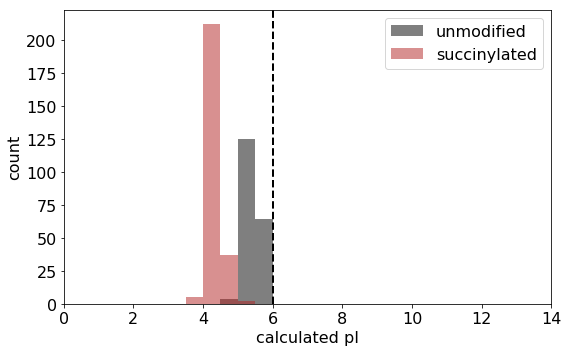

In [22]:
fig, ax = plt.subplots(figsize=(8,5))
native_pi = []
succ_pi = []
count = 0
for rs in rxn_syst.yield_rxn_syst(output_dir):  
    count += 1
    # collect pIs of all sequences even if reaction is skipped elsewhere
    if rs.skip_rxn is True and rs.UniprotID != '' and rs.UniprotID != None:
        try:
            pI = rs.pI
        except AttributeError:
            print('calculating pI')
            IDs = rs.UniprotID.split(" ")
            total_sequence = ''
            for i in IDs:
                sequence = Uniprot_IO.get_sequence(i)
                total_sequence += sequence
            rs = pi_fn.calculate_rxn_syst_pI(total_sequence, rs, param_dict=param_dict)
            rs.save_object(output_dir+rs.pkl)
    
    if rs.UniprotID != '' and rs.UniprotID != None:
        if rs.req_mod == None:
            native_pi.append(rs.pI)
        else:
            succ_pi.append(rs.pI)
        
ax.hist(native_pi,
        facecolor='k',
        alpha=0.5,
        histtype='stepfilled',
        bins=np.arange(0, 14 + 0.2, 0.5),
        label='unmodified')

ax.hist(succ_pi,
        facecolor='firebrick',
        alpha=0.5,
        histtype='stepfilled',
        bins=np.arange(0, 14 + 0.2, 0.5),
        label='succinylated')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('calculated pI', fontsize=16)
ax.set_ylabel('count', fontsize=16)
ax.set_xlim(0, 14)
# plot pI cut-off
ax.axvline(x=param_dict['cutoff_pi'], c='k', lw='2', linestyle='--')
# legend
ax.legend(fontsize=16)

fig.tight_layout()
fig.savefig(output_dir+"pI_dist.pdf",
            dpi=720, bbox_inches='tight')

### Plot pI vs maximum component size

In [23]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


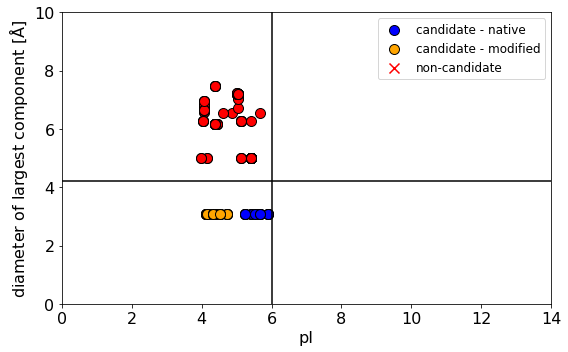

In [24]:
fig, ax = plt.subplots(figsize=(8,5))
# iterate over reaction system files
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is True:
        continue
        
    if rs.seed_MOF is None:
        continue
    
    if rs.all_fit is True and rs.seed_MOF is True:
        M = 'o'
        if rs.req_mod is not None:
            C = 'orange'
        else:
            C = 'b'
        E = 'k'
    else:
        #if rs.pI < 6 or rs.max_comp_size < 4.2:
        #    print(rs.seed_MOF, rs.all_fit, rs.pkl, rs.pI, rs.max_comp_size)
        #    input('done')
        M = 'o'
        C = 'r'
        E = 'k'
        
    ax.scatter(rs.pI,
               rs.max_comp_size, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
# decoy legend
ax.scatter(-100, 100,
           c='b', 
           edgecolors=E,
           marker='o', 
           alpha=1.0,
           s=100,
           label='candidate - native')
ax.scatter(-100, 100,
           c='orange',
           edgecolors=E,
           marker='o',
           alpha=1,
           s=100,
           label='candidate - modified')
ax.scatter(-100, 100,
           c='r',
           edgecolors=E,
           marker='x',
           alpha=1,
           s=100,
           label='non-candidate')

ax.legend(loc=1, fontsize=12)

ax.axhline(y=threshold, c='k')
ax.axvline(x=param_dict['cutoff_pi'], c='k')
define_plot_variables(ax,
                      title='',
                      xtitle='pI',
                      ytitle='diameter of largest component [$\mathrm{\AA}$]',
                      xlim=(0, 14),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"size_vs_pI.pdf", dpi=720,
            bbox_inches='tight')

### Plot # of reactions vs threshold value

In [25]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


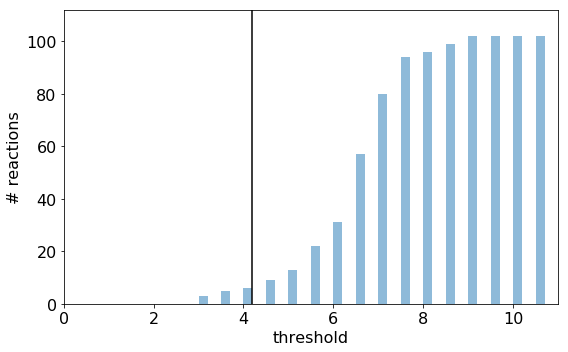

In [26]:
fig, ax = plt.subplots(figsize=(8,5))
max_sizes = []
reaction_reported = [] 
# iterate over reaction system files
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is True:
        continue
    # get list of SMILES of all components
    r_smiles = []
    r_MW = []
    for r in rs.components:
        r_smiles.append(r.SMILES)
        r_MW.append(Descriptors.MolWt(r.mol))
    r_smiles = [x for _, x in sorted(zip(r_MW, r_smiles))]
    if r_smiles in reaction_reported:
        continue
    else:
        reaction_reported.append(r_smiles)
    try:
        if rs.max_comp_size > 0:
            max_sizes.append(rs.max_comp_size)
    except AttributeError:
        pass

    
max_sizes = np.asarray(max_sizes)
counts = []
threshs = np.arange(0.1, 21, 0.5)
for thr in threshs:
    count_above = len(max_sizes[max_sizes < thr])
    counts.append(count_above)
    
ax.bar(threshs, counts, align='center', alpha=0.5, width=0.2)

ax.axvline(x=threshold, c='k')

define_plot_variables(ax,
                      title='',
                      xtitle='threshold',
                      ytitle='# reactions',
                      xlim=(0, 11),
                      ylim=(0, max(counts)+10))
fig.tight_layout()
fig.savefig(output_dir+"size_vs_threshold.pdf", dpi=720,
            bbox_inches='tight')

### Categorize all molecules in output file

In [27]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticklabels(['diffuses', 'does not diffuse'])
    ax.set_xticks([0.25, 0.75])

In [28]:
molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)

unique molecule that fits: H2O - DB: SABIO - ID: 40.0
unique molecule that fits: O2 - DB: SABIO - ID: 1264.0
unique molecule that fits: H2O2 - DB: SABIO - ID: 1909.0
unique molecule that fits: NH3 - DB: SABIO - ID: 1268.0
unique molecule that fits: CO2 - DB: SABIO - ID: 1266.0
unique molecule that fits: methanol - DB: BRENDA - ID: 17790.0
unique molecule that fits: formaldehyde - DB: BKMS - ID: 16842.0
unique molecule that fits: Ca2+ - DB: SABIO - ID: 1289.0
unique molecule that fits: CN- - DB: SABIO - ID: 2269.0
unique molecule that fits: dioxygen - DB: BKMS - ID: 15379.0
unique molecule that fits: thiocyanate - DB: BRENDA - ID: 18022.0
unique molecule that fits: chloride - DB: BRENDA - ID: 17996.0
unique molecule that fits: hypochlorous acid - DB: BRENDA - ID: 24757.0
unique molecule that fits: superoxide - DB: BKMS - ID: 18421.0
unique molecule that fits: hydron - DB: BKMS - ID: 15378.0
unique molecule that fits: bromide - DB: BKMS - ID: 15858.0
unique molecule that fits: hypobromou

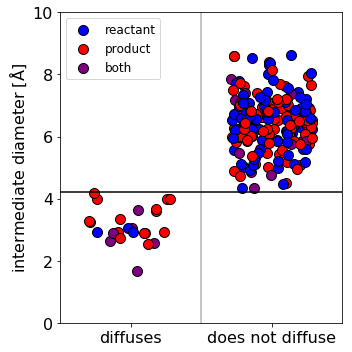

In [29]:
dx = 0.15
fig, ax = plt.subplots(figsize=(5,5))
for idx, row in molecule_output.iterrows():
    mid_diam = row['mid_diam']
    if mid_diam == 0:
        continue
    if mid_diam <= threshold:
        M = 'o'
        E = 'k'
        D = 0.25
        print('unique molecule that fits:', row['name'], 
              '- DB:', row['DB'], '- ID:', row['DB_ID'])
    else:
        M = 'o'
        E = 'k'
        D = 0.75
    
    # set colour based on role
    if row['role'] == 'reactant':
        C = 'b'
    elif row['role'] == 'product':
        C = 'r'
    elif row['role'] == 'both':
        C = 'purple'
    
    ax.scatter(D+(dx*(np.random.random() - 0.5) * 2),
               mid_diam, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
# decoy legend
ax.scatter(-100, 100,
           c='b', 
           edgecolors=E, marker='o', alpha=1.0,
           s=100,
           label='reactant')
ax.scatter(-100, 100,
           c='r', 
           edgecolors=E, marker='o', alpha=1.0,
           s=100,
           label='product')
ax.scatter(-100, 100,
           c='purple', 
           edgecolors=E, marker='o', alpha=1.0,
           s=100,
           label='both')

ax.legend(loc=2, fontsize=12)

ax.axhline(y=threshold, c='k')
ax.axvline(x=0.5, c='k', alpha=0.3)
define_plot_variables(ax,
                      title='',
                      xtitle='',
                      ytitle='intermediate diameter [$\mathrm{\AA}$]',
                      xlim=(0, 1),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"categorical.pdf", dpi=720,
            bbox_inches='tight')

In [30]:
molecule_output

,name,iupac_name,DB,DB_ID,SMILE,role,min_diam,mid_diam,max_diam,ratio_1,ratio_2
0,H2O,oxidane,SABIO,40.0,O,both,2.492,2.586,3.748,0.347,0.653
1,O2,Molecular oxygen,SABIO,1264.0,[O],both,2.635,2.639,2.675,0.000,0.000
2,H2O2,hydrogen peroxide,SABIO,1909.0,OO,both,2.767,3.070,4.138,0.101,0.984
3,NH3,azanide,SABIO,1268.0,N,product,2.702,2.928,3.475,0.636,0.636
4,Urea,UREA,SABIO,1798.0,N=C(N)O,reactant,2.908,5.012,5.671,0.446,0.554
5,CO2,carbon dioxide,SABIO,1266.0,O=C=O,product,2.757,2.898,5.388,0.000,1.000
6,sucrose,"(2R,3R,4S,5S,6R)-2-[(2S,3S,4S,5R)-3,4-dihydrox...",KEGG,17992.0,OCC1OC(OC2(CO)OC(CO)C(O)C2O)C(O)C(O)C1O,reactant,0.000,0.000,0.000,0.000,0.000
7,beta-D-fructofuranose,"(2R,3S,4S,5R)-2,5-bis(hydroxymethyl)oxolane-2,...",KEGG,28645.0,O[CH2:1][C@@:2]1(O)O[C@H:5]([CH2:6]O)[C@@H:4](...,product,5.364,7.017,8.523,0.498,0.682
8,alpha-D-glucose,"6-(hydroxymethyl)oxane-2,3,4,5-tetrol",KEGG,17925.0,O[C@H:1]1O[C@H:5]([CH2:6]O)[C@@H:4](O)[C@H:3](...,both,4.862,7.193,8.328,0.444,0.734
9,raffinose,"(2R,3R,4S,5S,6R)-2-[(2S,3S,4S,5R)-3,4-dihydrox...",BKMS,16634.0,OC[C@H]1O[C@@](CO)(O[C@H]2O[C@H](CO[C@H]3O[C@H...,both,0.000,0.000,0.000,0.000,0.000


### print all reactions that fit

In [31]:
reaction_reported = []
# iterate over reaction system files
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is True:
        continue
    # get list of SMILES of all components
    r_smiles = []
    r_MW = []
    for r in rs.components:
        r_smiles.append(r.SMILES)
        r_MW.append(Descriptors.MolWt(r.mol))
    r_smiles = [x for _, x in sorted(zip(r_MW, r_smiles))]
    if r_smiles in reaction_reported:
        continue
    else:
        reaction_reported.append(r_smiles)
    if rs.all_fit is True:
        count += 1
        print("New Reaction:")
        rs.print_rxn_system()
        
print("There are", count, "new reactions!")

New Reaction:
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 23680
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
New Reaction:
-----------------------------------
EC: 1.11.1.6
Database: BKMS
Database ID: 8219
-----------------------------------
hydrogen peroxide  (ID: 16240) as reactant
SMILES: OO
methanol  (ID: 17790) as reactant
SMILES: CO
formaldehyde  (ID: 16842) as product
SMILES: C=O
water  (ID: 15377) as product
SMILES: O
-----------------------------------
All components will diffuse through!
-----------------------------------
New Reaction:
-----------------------------------
EC: 1.11.1.7
Database: BRENDA
Database ID: BR59
-----------------------------------
chloride  (ID: 17996) as reactant
SMILES: [Cl-]
hydrogen peroxide  (ID: 16240) as

## Timing Information

#### pI screening - all sequences in BRENDA

(0, 30000)

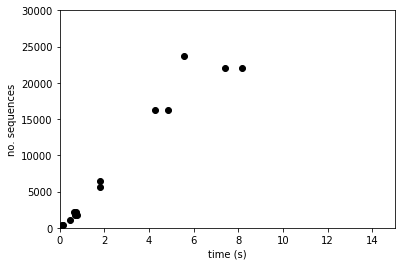

In [32]:
times = [0.74, 8.18, 4.85, 0.13, 0.02, 0.78, 
         0.62, 7.42, 4.26, 0.11, 0.01, 0.67, 
         300.89, 1.81, 0.03, 1.82, 0.44, 5.56]
seqs = [2220, 22068, 16288, 379, 36, 1765, 2220,
        22068, 16288, 379, 36, 1765, 1253592,
        6487, 80, 5665, 1098, 23660]
plt.scatter(times, seqs, c='k')
plt.xlabel('time (s)')
plt.ylabel('no. sequences')
plt.xlim(0, 15)
plt.ylim(0, 30000)

#### molecule screening

In [34]:
print('time taken to do molecule screening:')
print('collect reaction systems:', 1*60*60 + 47*60 + 34, 's')
print('accessibility:', 1*60*60 + 0*60 + 49, 's')
print('pI analysis:', 0*60*60 + 7*60 + 55, 's')
print('total:', 2*60*60 + 54*60 + 34 + 49 + 55, 's ==', (2*60*60 + 54*60 + 34 + 49 + 55) / 60 / 60, 'h')

time taken to do molecule screening:
collect reaction systems: 6454 s
accessibility: 3649 s
pI analysis: 475 s
total: 10578 s
